In [108]:
from scipy.stats import poisson

import random
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
from io import StringIO

import seaborn as sns

import scipy.stats as st

import copy

import re

In [344]:

pd.set_option('max_columns', 100)

pd.options.display.float_format = '{:,.4f}'.format

# class

## common

In [267]:
state_per_rating = {
    "avoid" : 0.01,
    "block" : 0.01,
    "expertise" : 0.01,
    "hit" : 0.01,
    "crit" : 0.01,
    "haste" : 0.01,
}

In [268]:
import random


def rng(p):
    return random.random() < p


class Tank():
    def __init__(self, avoid_rate, block_rate, parry_chance=0.14, boss_speed=2.4, armor = 15000,
                 block_interval=5, block_charges=2, block_amount=0.75, attack_speed=1.6, gcd_interval=1.5, dw=False, thrush=False, random_block = False):
        self.avoid_rate = avoid_rate
        self.block_rate = block_rate
        self.boss_speed = boss_speed
        self.parry_chance = parry_chance
        self.block_interval = block_interval
        self.block_charges = block_charges
        self.block_amount = block_amount
        self.attack_speed = attack_speed
        self.gcd_interval = gcd_interval
        self.dw = dw
        self.thrush = thrush
        self.random_block = random_block
        self.armor_scale = min(armor + 11960, 11960 * 4) / min(armor * 1.25 + 11960, 11960 * 4)
        
        self.reset()

    def reset(self):
        self.time = 0
        self.boss_next_attack_time = random.random() * self.boss_speed
        self.boss_next_off_attack_time = random.random() * self.boss_speed
        self.player_gcd_time = random.random() * self.gcd_interval
        self.player_attack_time = random.random() * self.attack_speed
        self.block_time = random.random() * self.block_interval
        self.block_count = self.block_charges
        self.random_block_time = 0
        self.random_block_count = 0
        self.armor_time = 0
        self.armor_check_time = 0

    def parry_check(self):
        if rng(self.parry_chance):
            p = (self.boss_next_attack_time - self.time) / self.boss_speed
            if p > 0.6:
                self.boss_next_attack_time -= self.boss_speed * 0.4
            elif p > 0.2:
                self.boss_next_attack_time = self.time + 0.2 * self.boss_speed

    def get_boss_attack_result(self, damage_scale = 1):
        roll = random.random()
        block_chance = self.block_rate
        if self.block_count > 0:
            block_chance += self.block_amount
        if self.random_block and self.time < self.random_block_time + 10 and self.random_block_count > 0:
            block_chance += 0.3
        if roll < self.avoid_rate:
            result = "a"
        elif roll < self.avoid_rate + block_chance:
            result = "b"
            if self.block_count > 0:
                self.block_count -= 1
            elif self.random_block_count > 0:
                self.random_block_count  -= 1
        elif roll < self.avoid_rate + block_chance + 0.15:
            result = "c"
        else:
            result = "h"
        if self.random_block and (result in ["h", "b", "c"]):
            if rng(0.1):
                self.random_block_time = self.time
                self.random_block_count = 5
        damage = damage_scale * (0.85 + 0.3 * random.random())
        if self.time < self.armor_time:
            damage *= self.armor_scale
        return (self.time, result, damage)
                
    def calculate_attack_result(self, duration=360):
        self.reset()
        attack_result_list = []
        while self.time < duration:
            if self.time >= self.boss_next_attack_time:
                self.boss_next_attack_time += self.boss_speed
#                 print(f"{self.time:0.2f}: attacked", result, self.block_count)
                attack_result_list.append(self.get_boss_attack_result())
                if self.thrush and rng(0.1):
                    attack_result_list.append(self.get_boss_attack_result())
                    attack_result_list.append(self.get_boss_attack_result())
            elif self.dw and self.time >= self.boss_next_off_attack_time:
                self.boss_next_off_attack_time += self.boss_speed
                attack_result_list.append(self.get_boss_attack_result(0.25))
            elif self.gcd_interval > 0 and self.time >= self.player_gcd_time:
                self.player_gcd_time += self.gcd_interval
                self.parry_check()
            elif self.attack_speed > 0 and self.time >= self.player_attack_time:
                self.player_attack_time += self.attack_speed
                self.parry_check()
            elif self.block_charges > 0 and self.time >= self.block_time:
                self.block_time += self.block_interval
                self.block_count = self.block_charges
            elif self.time >= self.armor_check_time:
                self.armor_check_time += 1.25
                if rng(0.1):
                    self.armor_time = self.time + 15
            else:
                times = [self.boss_next_attack_time, self.armor_check_time]
                if self.dw:
                    times.append(self.boss_next_off_attack_time)
                if self.gcd_interval > 0:
                    times.append(self.player_gcd_time)
                if self.attack_speed > 0:
                    times.append(self.player_attack_time)
                if self.block_charges > 0:
                    times.append(self.block_time)
                self.time = min(times)
        return attack_result_list


class WarriorTank(Tank):
    def __init__(self, *args, attack_speed = 1.6, gcd_interval = 1.5, **kwargs):
        super().__init__(*args, **kwargs, block_interval=5, block_charges=2, attack_speed=attack_speed, gcd_interval=gcd_interval)


class DruidTank(Tank):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs, block_interval=0, block_charges=0, attack_speed=2.5, gcd_interval=1.5)


class PaladinTank(Tank):
    def __init__(self, *args, attack_speed = 1.8, **kwargs):
        super().__init__(*args, **kwargs, block_interval=10, block_charges=8, block_amount=0.3, attack_speed=attack_speed, gcd_interval=0)


class PaladinTankWithLoR(Tank):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs, block_interval=10, block_charges=8, block_amount=0.3533, attack_speed=1.8, gcd_interval=0)

In [269]:

type_damages = {
    "a":0, 
    "b":1,
    "c":1.5,
    "h":1
}
def get_damage(d, block_dr = 0.06):
    r = type_damages[d[1]] * d[2]
    if d[1] == "b":
        r = max(0, r - block_dr)
    return r

def calculate_min_alive_time(result, hda = 4, block_dr = 0.06):
    i = 0
    j = 0
    r = 0
    rs = []
    while j < len(result):
        if r < hda:
            r += get_damage(result[j], block_dr)
            j += 1
        else:
            rs.append(result[j][0] - result[i][0])
            r -= get_damage(result[i], block_dr)
            i += 1
    return min(rs, default = 360)

def calculate_min_alive_time_for_pally(result, hda = 4, block_dr = 0.06):
    i = 0
    j = 0
    rs = []
    while j < len(result):
        r = 0
        for d in result[i:j]:
            damage = get_damage(d, block_dr)
            if r > hda * 0.65:
                damage *= 0.7
            r += damage
        if r < hda:
            j += 1
        else:
            rs.append(result[j][0] - result[i][0])
            i += 1
    return min(rs, default = 360)


def calculate_mean_alive_time(result, hda = 4, block_dr = 0.06):
    i = 0
    j = 0
    r = 0
    rs = []
    while j < len(result):
        if r < hda:
            r += get_damage(result[j], block_dr)
            j += 1
        else:
            rs.append(result[j][0] - result[i][0])
            r -= get_damage(result[i], block_dr)
            i += 1
    return np.mean(rs)
        

In [270]:
def print_bins(times):
    sorted_times = sorted(times)
    print(f"最小值 = {sorted_times[0]:0.2f}, 0.2%分位数 = {sorted_times[len(times)//500]:0.2f}, 0.5%分位数 = {sorted_times[len(times)//200]:0.2f}, 1%分位数 = {sorted_times[len(times)//100]:0.2f}, 2%分位数 = {sorted_times[len(times)//50]:0.2f}, 5%分位数 = {sorted_times[len(times)//20]:0.2f}")

def plot_dist(times, title):
    plt.figure(figsize=(8,6))
    plt.hist(times, bins = 50)
    plt.grid(b=True, which='both', axis='both')
    plt.xlim(4, 15)
    plt.title(title)

In [271]:
def get_state(gear_str, key):
    try:
        return float(re.search(f"\n{key}: ([\d\\.]+)", gear_str).groups()[0])
    except Exception:
        return 0
    

In [272]:
def get_line_result(player_state, boss_state, states_dict, calculate_function, min_y=1):
    results = {}
    for state_name, states in states_dict.items():
        xs = []
        ys = []
        print(f"calculating {state_name}")
        for s in states:
            state = copy.deepcopy(player_state)
            b_state = copy.deepcopy(boss_state)
            if state_name[:2]=="B-":
                b_state[state_name[2:]] += s
            else:
                state[state_name] += s
            r = calculate_function(state, b_state)
            xs.append(s)
            ys.append(r)
        slope, intercept, r_value, p_value, std_err = st.linregress(xs, ys)
        slope2, intercept, r_value, p_value, std_err = st.linregress(xs[:len(xs)//2], ys[:len(xs)//2])
        slope3, intercept, r_value, p_value, std_err = st.linregress(xs[len(xs)//2:], ys[len(xs)//2:])
        plt.plot(xs, ys)
        mean = sum(ys)/len(ys)
        scale = state_per_rating.get(state_name, 1)
        plt.grid("both") 
        plt.title(f"{state_name} - slope: {slope/mean * scale * 1e5:0.2f}, dec: {slope2/mean * scale * 1e5:0.2f}, inc: {slope3/mean * scale * 1e5:0.2f}")
        results[state_name] = {
            "slope": slope/mean * scale,
            "slope_dec": slope2/mean * scale,
            "slope_inc": slope3/mean * scale,
            "xs": xs,
            "ys": ys,
        }
        if max(ys) - min(ys) < min_y:
            plt.ylim([mean - min_y/2, mean + min_y/2])
        plt.show()
    return results

In [273]:
def get_slope(r, k):
    if k in r:
        return r[k]["slope"] * 1e5
    return 0

## warrior

In [501]:
warrior_base_state = dict(
    
    physics_damage = 1,
    damage = 1,
    str=159,
    agi=96,
    sta=139,

    hp=5654,
    avoid=(10.8 + 4.75 + 0.8 + 5 - 1.8) * 0.01,
    block=(10.8 - 0.6) * 0.01,
    blockValue=9,
    armor=192,

    ap=508,
    crit=0.0705 - 0.006 + 0.05,
    hit=0.00,
    expertise=0.0125 + 0.015,
    weapon_dps=0,
    weapon_speed=2,

    boss_armor=7700,
    windfury=False,
    haste = 0,
    
    boss_dr = 0,
    defense = 0,
)
warrior_base_state["class"] = "warrior"

In [548]:
def warrior_get_geared_state(gear_str, use_def=False, stage=0):
    state = copy.copy(warrior_base_state)
    
    strength = int(re.search("力量: (\d+)", gear_str).groups()[0])
    state["str"] += int(strength * 1.1)
    
    agi = int(re.search("敏捷: (\d+)", gear_str).groups()[0]) + 12 + 15 + 10 + 20
    
    defense = (int(re.search("防御等级: (\d+)", gear_str).groups()[0]) + 16 + 10)
    rel = get_state(gear_str, "韧性等级")
    block = int(re.search("格挡等级: (\d+)", gear_str).groups()[0]) / 7.88

    gem_sta = (get_state(gear_str, "红色插槽") + get_state(gear_str, "黄色插槽") + get_state(gear_str, "蓝色插槽")) * 2
    
    sta = int(re.search("耐力: (\d+)", gear_str).groups()[0])+ 30 + 30
        
    if stage>0:
        defense += 10
        sta+=10
        agi+=2
        
    block_scale = 1.3
    if stage > 0 and get_state(gear_str, "多彩插槽") > 1:
        block_scale = 1.35
        defense += 15
    if defense/59.25 + rel/39.4 < 4.8: #胸
        defense += 15
        print(defense)
    else:
        state["hp"] += 150
    if defense/59.25 + rel/39.4 < 4.8: #手腕
        defense += 12
        print(defense)
    else:
        sta += 12
        
    gem_pc = 3 if stage == 0 else 4 if stage == 1 else 5
    if use_def:           #宝石盾牌,鞋
        defense += gem_sta * gem_pc
        block += 15 / 7.88
        agi += 12
    else:
        if defense/59.25 + rel/39.4 < 4.8:
            d = defense/59.25 + rel/39.4 - 4.8
            dg = min(int(- d * 59.25/gem_pc) + 1, gem_sta)
            defense += dg * gem_pc
            sta += (gem_sta - dg) * gem_pc * 1.5
        else:
            sta += gem_sta * gem_pc * 1.5
        sta += 18
        sta += 12 
    
    state["sta"] += int(sta * 1.05)
    state["hp"] += int(sta * 10.5 + 500)
    state["agi"] += int(agi)
    
    state["defense"] = defense
    
    defense = defense / 59.25
    dodge = (int(re.search("躲闪等级: (\d+)", gear_str).groups()[0]) + 17 + 13) / 18.9232
    parry = int(re.search("招架等级: (\d+)", gear_str).groups()[0]) / 23.56
    blockValue = int(re.search("格挡值: (\d+)", gear_str).groups()[0])
    armor = int(re.search("护甲: (\d+)", gear_str).groups()[0])
    state["avoid"] += (defense * 3 + dodge + parry) * 0.01 + agi / 30 * 0.01
    state["block"] += (block + defense) * 0.01
    state["blockValue"] += blockValue * block_scale  + strength * 1.1 * 0.05
    state["armor"] += armor * 1.1 + agi * 2 + 2500
    ap = get_state(gear_str, "攻击强度")
    crit = get_state(gear_str, "暴击等级")/22.08
    hit = get_state(gear_str, "命中等级")/15.77
    expertise = int(get_state(gear_str, "精准等级")/15.77 * 4)/4
    
    state["ap"] += ap + strength * 2.2
    state["crit"] += (crit + agi / 33) * 0.01
    state["hit"] += hit * 0.01
    state["expertise"] += expertise * 0.01
    
    state["weapon_dps"] = get_state(gear_str, "近战武器dps")
    state["weapon_speed"] = get_state(gear_str, "近战武器速度")
    
    state["class"] = "warrior"
    
    return state

In [276]:
def warrior_add_raid_buffs(state):
    buffed_state = {**dict(
        physics_damage = state["physics_damage"] + 0.04,
        damage = state["damage"] + 0.02,

        hp=state["hp"] + state["sta"] * 0.1 * 10 + (19 * 1.1 + 91 * 1.1 + 102 * 1.1) * 1.05 * 10 + 1080,
        avoid=state["avoid"] + 0.05 + 0.02 + (state["agi"] * 0.1 + 89 * 1.1 + 19 * 1.1) / 33 * 0.01,
        blockValue=state["blockValue"] + (state["str"] * 0.1 + 99 * 1.1 * 1.1) * 0.05,
        block = state["block"],
        armor=state["armor"] + 1205 + 460,

        ap=(state["ap"] + 306*1.25 + 220*1.2 + 99 * 1.1 * 1.1 * 2 + state["str"] * 0.2) * 1.1,
        crit=state["crit"] + 0.05 + (state["agi"] * 0.1 + 89 * 1.1 + 19 * 1.1) / 33 * 0.01 + 14/22.09 * 0.01,
        hit=state["hit"] + 0.03,
        expertise=state["expertise"],
        weapon_dps=state["weapon_dps"] + 12/state["weapon_speed"],
        weapon_speed=state["weapon_speed"],
        haste = state["haste"],

        boss_armor=state["boss_armor"] - 2600 - 610 - 800,
        windfury = True,
        boss_dr = 0.05,
    )}
    return buffed_state


In [277]:
def warrior_calculate_tps(state, dtps):
    armor_taken = 10557 / (state["boss_armor"] + 10557)
    crit = state["crit"]
    ap = state["ap"]
    hit = state["hit"]
    expertise = state["expertise"]
    physics_damage = state["physics_damage"]
    damage = state["damage"]
    wf_scale = 1
    if state["windfury"]:
        wf_scale = 1 + 0.2 * (0.91 + hit - 0.14 - 0.065 + expertise * 2)
    wf_scale *= ( 1 + state["haste"])
    melee_dps = (ap / 14 + state["weapon_dps"]) * armor_taken * physics_damage * damage * (crit + 0.91 + hit - 0.14 - 0.065 + expertise * 2 - 0.25 * 0.35) * wf_scale
    ss_tps = (307 + (420 + state["blockValue"]) * (1 + crit) * armor_taken * physics_damage * damage) / 6
    revenge_tps = (201 + 414 * (1 + crit) * armor_taken * physics_damage * damage) / 6
    devastate_tps = (176 + (ap / 14 * 2.4 * 0.5 + state["weapon_dps"] * state["weapon_speed"] * 0.5 + 35 * 5)
                     * (1 + crit) * armor_taken * physics_damage * damage) * (6 / 24)
    tc_tps = (123 * 2 * 1.75 * damage) * (0.91 + hit) * (1 + crit * 0.5) * 0.97 / 24
    demo_tps = 56 * (0.91 + hit) / 24
    melee_rgps = melee_dps / 73.25 + (1.75 * 1 * (1 + crit) * wf_scale) * (0.91 + hit - 0.14 - 0.065 + expertise * 2)
    rgps = dtps / 109.9 + melee_rgps + 1/2.2 * 0.5
    melee_rgph = melee_rgps * state["weapon_speed"] 
    rcps = 17 / 6 + 2 / 6 + 9 * (6 / 24) + 13 / 24 + 7 / 24 + 10 / 5
    hs_cps = (rgps - rcps) / (12 + melee_rgph / wf_scale)
    if hs_cps < 0:
        devastate_tps *= (1 + (rgps - rcps) / (9 * (6 / 24)))
        hs_cps = 0
    if hs_cps < 0:
        print("not enough rage")
    hs_cps = min(hs_cps, 1 / state["weapon_speed"] * ( 1 + state["haste"]))
    hs_tps = (220 + 208 * (1 + crit) * armor_taken * physics_damage * damage) * hs_cps
    tps = (melee_dps + (ss_tps + revenge_tps + devastate_tps + hs_tps) * (0.91 + hit) * (1 - 0.14 - 0.065 + expertise * 2) + tc_tps + demo_tps) * 1.495
    if state["windfury"]:
        tps += (1/1.5 - 1/24 -1/24) * melee_dps * state["weapon_speed"] * (0.91 + hit) * (1 - 0.14 - 0.065 + expertise * 2) * 0.2 * 1.495
    return tps

In [278]:
def warrior_calculate_dps(state, dtps):
    armor_taken = 10557 / (state["boss_armor"] + 10557)
    crit = state["crit"]
    ap = state["ap"]
    hit = state["hit"]
    expertise = state["expertise"]
    physics_damage = state["physics_damage"]
    damage = state["damage"]
    wf_scale = 1
    if state["windfury"]:
        wf_scale = 1 + 0.2 * (0.91 + hit - 0.14 - 0.065 + expertise * 2)
    wf_scale *= ( 1 + state["haste"])
    melee_dps = (ap / 14 + state["weapon_dps"]) * (1 + crit) * armor_taken * physics_damage * damage * (0.91 + hit - 0.14 - 0.065 + expertise * 2 - 0.25 * 0.35) * wf_scale
   
    ss_tps = ((420 + state["blockValue"]) * (1 + crit) * armor_taken * physics_damage * damage) / 6
    revenge_tps = (414 * (1 + crit) * armor_taken * physics_damage * damage) / 6
    devastate_tps = ((ap / 14 * 2.4 * 0.5 + state["weapon_dps"] * state["weapon_speed"] * 0.5 + 35)
                     * (1 + crit) * armor_taken * physics_damage * damage) * (6 / 24)
    tc_tps = (123 * 2 * damage) * (0.91 + hit) * (1 + crit * 0.5) * 0.97 / 24
    demo_tps = 0
    rcps = 17 / 6 + 2 / 6 + 9 * (6 / 24) + 13 / 24 + 7 / 24 + 10 / 5
    melee_rgps = melee_dps / 73.25 + (1.75 * 1 * (1 + crit) * wf_scale) * (0.91 + hit - 0.14 - 0.065 + expertise * 2)
    rgps = dtps / 109.9 + melee_rgps
    melee_rgph = melee_rgps * state["weapon_speed"] 
    hs_cps = (rgps - rcps) / (12 + melee_rgph / wf_scale)
    hs_cps = min(hs_cps, 1 / state["weapon_speed"] * ( 1 + state["haste"]))
    hs_tps = (208 * (1 + crit) * armor_taken * physics_damage * damage) * hs_cps
    tps = (melee_dps + (ss_tps + revenge_tps + devastate_tps + hs_tps) * (0.91 + hit) * (1 - 0.14 - 0.065 + expertise * 2) + tc_tps )
    if state["windfury"]:
        tps += (1/1.5 - 1/24 -1/24) * melee_dps * state["weapon_speed"] * (0.91 + hit) * (1 - 0.14 - 0.065 + expertise * 2) * 0.2
    return tps

In [279]:
def warrior_calculate_effective_health(state):
    result = state["hp"] / (1 - 0.15) / ( (11960 / (state["armor"] + 11960)) * 0.9 ) / ( 1- state["boss_dr"])
    if state["boss_dr"] > 0:
        result /= ( 1- state["boss_dr"])
    return result

In [280]:
def warrior_calculate_alive_time(state, boss_state, iterate_times = 1000):
    boss_damage = boss_state["damage"]
    boss_speed = boss_state["speed"]
    avoid = state["avoid"]
    block = state["block"]
    warrior = WarriorTank(avoid, block, parry_chance = 0.14 - state["expertise"], armor=state["armor"], boss_speed = boss_speed, attack_speed = state["weapon_speed"],
                         dw = boss_state.get("dw"), thrush=boss_state.get("thrush"))
    warrior_min_alive_times = []
    hdt = ( (11960 / (state["armor"] + 11960)) * 0.9 )
    bdr = state["blockValue"] / (boss_damage * ( 1 - state["boss_dr"]) * hdt)
    ehp = state["hp"] / hdt / ( 1- state["boss_dr"])
    
    for _ in range(iterate_times):
        result = warrior.calculate_attack_result()
        warrior_min_alive_times.append(calculate_min_alive_time(result, ehp / boss_damage, bdr))
    return sorted(warrior_min_alive_times)[iterate_times//20]

In [281]:
def warrior_calculate_alive_time_mean(state, boss_state, iterate_times = 1000):
    boss_damage = boss_state["damage"]
    boss_speed = boss_state["speed"]
    avoid = state["avoid"]
    block = state["block"]
    warrior = WarriorTank(avoid, block, parry_chance = 0.14 - state["expertise"], armor=state["armor"],  boss_speed = boss_speed, attack_speed = state["weapon_speed"],
                         dw = boss_state.get("dw"), thrush=boss_state.get("thrush"))
    warrior_min_alive_times = []
    hdt = ( (11960 / (state["armor"] + 11960)) * 0.9 )
    bdr = state["blockValue"] / (boss_damage * ( 1 - state["boss_dr"]) * hdt)
    ehp = state["hp"] / hdt / ( 1- state["boss_dr"])
    
    for _ in range(iterate_times):
        result = warrior.calculate_attack_result()
        warrior_min_alive_times.append(calculate_mean_alive_time(result, ehp / boss_damage, bdr))
    return np.mean(warrior_min_alive_times)

In [282]:
def warrior_calculate_dtps_sim(state, boss_state, iterate_times = 1000):
    boss_damage = boss_state["damage"]
    boss_speed = boss_state["speed"]
    avoid = state["avoid"]
    block = state["block"]
    warrior = WarriorTank(avoid, block, parry_chance = 0.14 - state["expertise"],  armor=state["armor"], boss_speed = boss_speed, attack_speed = state["weapon_speed"],
                         dw = boss_state.get("dw"), thrush=boss_state.get("thrush"))
    results = []
    hdt = ( (11960 / (state["armor"] + 11960)) * 0.9 )
    bdr = state["blockValue"] / (boss_damage * ( 1 - state["boss_dr"]) * hdt)
    ehp = state["hp"] / hdt / ( 1- state["boss_dr"])
    
    for _ in range(iterate_times):
        result = warrior.calculate_attack_result()
#         raise Exception("")
        results.append(sum([get_damage(r,bdr) * hdt * ( 1- state["boss_dr"]) * boss_damage for r in result])/360)
    return sum(results)/len(results)

In [283]:
def warrior_calculate_dtps(state, boss_state):
    hdt = ( (11960 / (state["armor"] + 11960)) * 0.9 )
    hdt2 = ( (11960 / min(state["armor"] * 1.25 + 11960, 11960 * 4)) * 0.9 )
    hdt += 0.717 * (hdt2-hdt)
    boss_damage = boss_state["damage"]
    boss_speed = boss_state["speed"]
    bdr = state["blockValue"] / (boss_damage * ( 1 - state["boss_dr"]) * hdt)
    bdr = min(bdr, 1)
#     print(bdr)
    ph = boss_speed * (1 / 1.5 + 1 / state["weapon_speed"]) * 0.24 * (0.14 - state["expertise"]) if boss_state["parry_haste"] else 0
    crush_p =  min(max(1- state["avoid"] - state["block"], 0), 0.15)
    block_p = min(1- state["avoid"], state["block"])
    bup = 0.95 if not boss_state.get("dw", False) else 0.65
    adt = (bup * (1 - state["avoid"]) * ( 1- bdr) + (1-bup) * (1 - state["avoid"] - block_p * bdr + 0.5 * crush_p)) * (1 + ph)
    if boss_state.get("thrush", False):
        adt *= 1.2
    if boss_state.get("dw", False):
        adt += 0.25 * (bup * (1 - state["avoid"]) * ( 1- min(1,bdr * 4)) + (1-bup) * (1 - state["avoid"] - block_p * min(1,bdr * 4) + 0.5 * crush_p))
    return boss_damage / boss_speed * ( 1- state["boss_dr"]) * adt * hdt
    

In [284]:


def warrior_generate_ag_str(point_name, gear_result, dec = False):
    s = -1 if dec else 1
    hp = get_slope(gear_result, "hp") * s
    armor = get_slope(gear_result, "armor") * s
    avoid = get_slope(gear_result, "avoid") * s
    blockValue = get_slope(gear_result, "blockValue") * s
    block = get_slope(gear_result, "block") * s
    expertise = get_slope(gear_result, "expertise") * s
    weapon_speed = get_slope(gear_result, "weapon_speed") * s
    
    ap = get_slope(gear_result, "ap") * s
    hit = get_slope(gear_result, "hit") * s
    crit = get_slope(gear_result, "crit") * s
    haste = get_slope(gear_result, "haste") * s
    weapon_dps = get_slope(gear_result, "weapon_dps") * s
    boss_armor = get_slope(gear_result, "boss_armor") * s
    ag_str = f"""^1^SAirjGear_point^T^SautoGems^B^Sname^S{point_name}^Senable^B^Svalues^T^S急速等级^N{haste/15.77:0.2f}^S爆击等级^N{crit/20.9:0.2f}^S命中等级^N{hit/15.77:0.2f}^S护甲穿透^N{-boss_armor:0.2f}^S近战武器dps^N{weapon_dps:0.2f}^S攻击强度^N{ap:0.2f}^S防御等级^N{avoid/59.25*3 + block/59.25:0.1f}^S格挡值^N{blockValue*1.3:0.1f}^S力量^N{ap*2.2*1.1+blockValue*1.21*0.05:0.2f}^S耐力^N{hp*10.5 * 1.1:0.1f}^S护甲^N{armor*1.1:0.1f}^S招架等级^N{avoid/22.4:0.1f}^S敏捷^N{avoid/30*1.1+armor*2.2+crit/33*1.1:0.1f}^S躲闪等级^N{avoid/18.92:0.1f}^S近战武器速度^N{weapon_speed:0.1f}^S格挡等级^N{block/7.88:0.1f}^S精准等级^N{expertise/15.77:0.1f}^t^t^^"""
    return ag_str

## druid

In [582]:
druid_base_state = dict(
    
    physics_damage = 1,
    damage = 1,
    str=75,
    agi=77,
    sta=126,

    hp=4694,
    avoid=(8.37 + 5 - 1.2) * 0.01,
    armor=154,

    ap=655,
    crit=0.1504 - 0.006,
    hit=0.00,
    expertise=0.00,

    boss_armor=7700,
    windfury=False,
    haste = 0,
    
    boss_dr = 0,
    weapon_speed = 2.5,
)
druid_base_state["class"] = "druid"


In [694]:
def druid_get_geared_state(gear_str, use_def=False, use_ench=True, stage=0):
    state = copy.copy(druid_base_state)

    strength = get_state(gear_str, "力量")

    agi = get_state(gear_str, "敏捷")

    defense = get_state(gear_str, "防御等级")
    rel = get_state(gear_str, "韧性等级")
    gem_sta = (get_state(gear_str, "红色插槽") + get_state(gear_str, "黄色插槽") +
               get_state(gear_str, "蓝色插槽")) * 2
    sta = get_state(gear_str, "耐力")
    if use_ench:
        agi += 12 + 15 + 10 + 35  # 披风/手套/腿/武器
        defense +=  + 16  # 头
        sta += 30 + 30 + 12  # 腿/食物/手腕
        
        if stage>0:
            defense += 10
            sta+=10
            agi+=2
        if use_def or defense/59.25 < 2.6 - 10 / 59.25 - 15 / 39.4:
            agi += 35
            rel += 30
        else:
            defense += 10
            state["hp"] += 500

        if defense/59.25 + rel/39.4 < 2.6:
            rel += 15
            print(defense)
        else:
            sta += 6
            agi += 6
            strength += 6

        if stage > 0 and get_state(gear_str, "多彩插槽") > 1:
            sta += 18
        gem_pc = 3 if stage == 0 else 4 if stage == 1 else 5
        if use_def:
            agi += gem_sta * gem_pc + 12  # 鞋
        else:
            if defense/59.25 + rel/39.4 < 2.6:
                d = defense/59.25 + rel/39.4 - 4.8
                dg = min(int(- d * 59.25/gem_pc) + 1, gem_sta)
                defense += dg * gem_pc
                sta += (gem_sta - dg) * gem_pc * 1.5
            else:
                sta += gem_sta * gem_pc * 1.5
            sta += 12  # 鞋
    state["sta"] += int(sta * 1.03 * 1.2 * 1.25)
    state["hp"] += int(sta * 1.03 * 1.2 * 1.25 * 10)
    state["agi"] += int(agi * 1.03)
    state["str"] += int(strength * 1.03)

    state["defense"] = defense
    state["rel"] = rel

    defense = defense / 59.25
    dodge = (get_state(gear_str, "躲闪等级") + (17 + 13 if use_ench else 0)) / 18.9232  # 头/ 肩
    armor = get_state(gear_str, "护甲")
    state["avoid"] += (defense * 2 + dodge) * 0.01 + agi * 1.03 / 14.7 * 0.01
    state["armor"] += armor * 1.1 * 5 + agi * 1.03 * 2 + (2500 if use_ench else 0)
    ap = get_state(gear_str, "攻击强度") + get_state(gear_str, "野性强度")
    crit = get_state(gear_str, "暴击等级")/22.08
    hit = get_state(gear_str, "命中等级")/15.77
    expertise = int(get_state(gear_str, "精准等级")/15.77 * 4)/4

    state["ap"] += ap + strength * 1.03 * 2
    state["crit"] += (crit + agi / 25) * 0.01
    state["hit"] += hit * 0.01
    state["expertise"] += expertise * 0.01
    state["class"] = "druid"

    return state

In [459]:
def druid_add_raid_buffs(state):
    buffed_state = {**dict(
        physics_damage = state["physics_damage"] + 0.04,
        damage = state["damage"] + 0.02,

        hp=state["hp"] + state["sta"] * 0.1 * 10 + (19 * 1.1 + 91 * 1.1 + 102 * 1.1) * 1.5 * 1.03 * 10 + 1080,
        avoid=state["avoid"] + 0.05 + 0.02 + (19 * 1.1 + state["agi"] * 0.1 + 89 * 1.1) * 1.03 / 14.7 * 0.01,
        armor=state["armor"] + 1205 + 460,
        haste=state["haste"],

        ap=(state["ap"] + 306*1.25 + 220*1.2 + (19 + 89) * 1.1 * 1.03 * 2 + state["str"] * 0.2) * 1.1,
        crit=state["crit"] + 0.05 + (state["agi"] * 0.1 + (19 + 89) * 1.1 * 1.03 + 19 * 1.1 * 1.03) / 25 * 0.01,
        hit=state["hit"] + 0.03,
        expertise=state["expertise"],
        boss_armor=state["boss_armor"] - 3075 - 800 - 610,
        boss_dr = state["boss_dr"] + 0.05
    )}
    return buffed_state


In [886]:
def druid_calculate_tps(state, dtps):
    armor_taken = 10557 / (state["boss_armor"] + 10557)
    crit = state["crit"]
    ap = state["ap"]
    hit = state["hit"]
    haste = state["haste"]
    expertise = state["expertise"]
    physics_damage = state["physics_damage"] * 1.1
    damage = state["damage"]
    melee_dps = (ap / 14 + 63) * armor_taken * physics_damage * damage * \
        (crit + 0.91 + hit - 0.14 - 0.065 + expertise * 2 - 0.25 * 0.35) * (1 + haste)

    mango_tpc = (52 * 0 + 155.25 + (ap/14 + 63) * 2.5 * 1.15) * (1 + crit) * armor_taken * physics_damage * damage * 1.3
    lacerate_dot_tps = (0 * 8 + 155 + ap * 0.05) * 5 / 15 * physics_damage * damage * 0.2
    lacerate_tpc = (285 + (31 + 0 * 8) * (1 + crit) * armor_taken * physics_damage * damage * 0.2)
    swipe_tpc = (84 + ap * 0.07) * (1 + crit) * armor_taken * physics_damage * damage
    hs_tpc = 322 + (176 + 50 * 1) * (1 + crit) * armor_taken * physics_damage * damage
    hsa_tpc = 322 + (176 + 50 * 1 + (ap / 14 + 63) * 2.5) * (1 + crit) * armor_taken * physics_damage * damage
    ff_tpc = 127

    melee_spell_scale = (0.91 + hit) * (1 - 0.14 - 0.065 + expertise * 2)
    rage_scale = (1 - 0.083)
    gcd_used = 0
    rgps = dtps / 109.9 + (1 + haste) * crit * 5 / 2.5
    tps = mango_tpc / 6 * melee_spell_scale

    rgps -= (15 * rage_scale - 5 * crit * melee_spell_scale) / 6
    gcd_used += 1.5/6

    tps += 1/12 * lacerate_tpc / 12
    gcd_used += 1.5/12/melee_spell_scale
    rgps -= (13 * rage_scale - 5 * crit * melee_spell_scale) / 12 / melee_spell_scale
    melee_rgps = melee_dps / 73.25 + (1.75 * 1 * (1 + crit)) * (0.91 + hit - 0.14 - 0.065 + expertise * 2)
    melee_rgph = melee_rgps * (2.5 / (1+haste))
    
    if rgps > (10 / 2.5) * (1+haste):
        tps += hsa_tpc / 2.5 * (1+haste) * melee_spell_scale
        rgps -= 10 / 2.5 * (1+haste)
#         print("full maul")
    else:
        hs_pr = (melee_rgps + rgps) / (10 / 2.5 * (1 + haste) + melee_rgps)
        tps += hsa_tpc / 2.5 * (1+haste) * hs_pr * melee_spell_scale
        tps += melee_dps * (1-hs_pr)
        
#         print(f"maul p = {hs_pr}")
        rgps = 0
    if rgps >-1:
        swipe_cps = min(rgps / (15 * rage_scale - 5 * crit * melee_spell_scale), (1-gcd_used) / 1.5)
        swipe_tps = swipe_cps * swipe_tpc * melee_spell_scale
        if swipe_cps * 1.5 + gcd_used < 1:
            swipe_tps += ff_tpc * min(1/6, (1-gcd_used) / 1.5 - swipe_cps) * 0.83
            
            
        lacerate_cps = min(rgps / (13 * rage_scale - 5 * crit * melee_spell_scale), (1-gcd_used) / 1.5)
        lacerate_tps = lacerate_cps * lacerate_tpc * melee_spell_scale
        if lacerate_cps * 1.5 + gcd_used < 1:
            lacerate_tps += ff_tpc * min(1/6, (1-gcd_used) / 1.5 - lacerate_cps) * 0.83
        
#         print(f"swipe = {swipe_tps}, lacerate = {lacerate_tps}")
        tps += max(swipe_tps, lacerate_tps)
        
#     print(mango_tps * 6 , lacerate_tpc, swipe_tpc, hs_tpc, hs_cps)
    return (tps + lacerate_dot_tps) * 1.495

In [869]:
# def druid_calculate_dps(state, dtps):
#     armor_taken = 10557 / (state["boss_armor"] + 10557)
#     crit = state["crit"]
#     ap = state["ap"]
#     hit = state["hit"]
#     expertise = state["expertise"]
#     physics_damage = state["physics_damage"]
#     damage = state["damage"]
#     melee_dps = (ap / 14 + 63) * (1 + crit) * armor_taken * physics_damage * damage * (0.91 + hit - 0.14 - 0.065 + expertise * 2 - 0.25 * 0.35)
#     mango_tps = (155.25 + (ap/14 + 63) * 2.5 * 1.15) * (1 + crit) * armor_taken * physics_damage * damage * 1.3 / 6
#     lacerate_dot_tps = (155 + ap * 0.05) * 5 / 15 * physics_damage * damage * 0.2
#     lacerate_tpc = (285 + 31 * (1 + crit) * armor_taken * physics_damage * damage * 0.2)
#     swipe_tpc = (84 + ap * 0.07) * (1 + crit) * armor_taken * physics_damage * damage
#     hs_tpc = (322 + 176 * (1 + crit) * armor_taken * physics_damage * damage)
#     ff_tpc = 127
    
#     melee_rgps = melee_dps / 73.25 + (1.75 * 1 * (1 + crit)) * (0.91 + hit - 0.14 - 0.065 + expertise * 2)
#     melee_rgph = melee_rgps * 2.5
#     rgps = dtps / 109.9 + melee_rgps + (1/2.5 * crit + 1/1.5 * crit*(0.91 + hit - 0.14 - 0.065 + expertise * 2))*5 + (1/2.5 * 0.083 + 1/1.5 * 0.083*(0.91 + hit - 0.14 - 0.065 + expertise * 2))*12
    
#     if lacerate_tpc > swipe_tpc:
#         lacerate_cps = 3 / 6
#         swipe_cps = 0
#         lacerate_cps_ff = 2 / 6
#         swipe_cps_ff = 0
#         rcps_ff = 15 / 6 + 2 / 6 * 13 + 15 * swipe_cps
#     else:
#         lacerate_cps = 1 / 12
#         swipe_cps = 5 / 12
#         lacerate_cps_ff = 1 / 12
#         swipe_cps_ff = 3 / 12
#         rcps_ff = 15 / 6 + 1/12 * 13 + 15 * 3 / 12
        
#     rcps = 15 / 6 + lacerate_cps * 13 + 15 * swipe_cps
#     hs_cps = (rgps - rcps) / (10 + melee_rgph)
#     hs_cps = min(hs_cps, 1 / 2.5)
    
#     hs_cps_ff = (rgps - rcps_ff) / (10 + melee_rgph)
#     hs_cps_ff = min(hs_cps_ff, 1 / 2.5)
#     ff_tps = 0
#     if (hs_cps_ff - hs_cps) * hs_tpc * (1 - 0.14 - 0.065 + expertise * 2) > ff_tpc / 6:
#         hs_cps = hs_cps_ff
#         lacerate_cps = lacerate_cps_ff
#         swipe_cps = swipe_cps_ff
#         ff_tps = ff_tpc / 6
# #         print("use ff")
#     if hs_cps < 0:
#         print('error')
#     print(mango_tps * 6 , lacerate_tpc, swipe_tpc, hs_tpc)
#     return (melee_dps + (mango_tps / 1.3 + (lacerate_tpc - 285) * 5 * lacerate_cps + swipe_tpc * swipe_cps + (hs_tpc - 322) * hs_cps) * (0.91 + hit) * (1 - 0.14 - 0.065 + expertise * 2) + lacerate_dot_tps * 5)

In [290]:
def druid_calculate_alive_time(state, boss_state, iterate_times = 1000):
    boss_damage = boss_state["damage"]
    boss_speed = boss_state["speed"]
    avoid = state["avoid"]
    driud = DruidTank(avoid, 0, parry_chance = 0.14 - state["expertise"], armor=state["armor"], boss_speed = boss_speed,
                         dw = boss_state.get("dw"), thrush=boss_state.get("thrush"))
    min_alive_times = []
    hdt = ( (11960 / (state["armor"] + 11960)))
    ehp = state["hp"] / hdt / ( 1- state["boss_dr"])
    
    for _ in range(iterate_times):
        result = driud.calculate_attack_result()
        min_alive_times.append(calculate_min_alive_time(result, ehp / boss_damage, 0))
    return sorted(min_alive_times)[iterate_times//20]
#     print_bins(min_alive_times)
#     plot_dist(min_alive_times, "warrior_quest_raid_buffed")
#     len([x for x in min_alive_times if x < 6.72])

In [291]:
def druid_calculate_dtps(state, boss_state):
    hdt = ( (11960 / (state["armor"] + 11960)) )
    hdt2 = ( (11960 / min(state["armor"] * 1.25 + 11960, 11960 * 4)))
    hdt += 0.717 * (hdt2-hdt)
    boss_damage = boss_state["damage"]
    boss_speed = boss_state["speed"]
#     print(bdr)
    ph = boss_speed * (1 / 1.5 + 1 / 2.5) * 0.24 * (0.14 - state["expertise"]) if boss_state["parry_haste"] else 1
    crush_p =  min(max(1- state["avoid"], 0), 0.15)
    adt = (1 - state["avoid"] + 0.5 * crush_p)
    return boss_damage / boss_speed * (1 + ph) * ( 1- state["boss_dr"]) * adt * hdt
    

In [292]:


def druid_generate_ag_str(point_name, gear_result, dec = False):
    s = -1 if dec else 1
    hp = get_slope(gear_result, "hp") * s
    armor = get_slope(gear_result, "armor") * s
    avoid = get_slope(gear_result, "avoid") * s
    blockValue = get_slope(gear_result, "blockValue") * s
    block = get_slope(gear_result, "block") * s
    expertise = get_slope(gear_result, "expertise") * s
    weapon_speed = get_slope(gear_result, "weapon_speed") * s
    
    ap = get_slope(gear_result, "ap") * s
    hit = get_slope(gear_result, "hit") * s
    crit = get_slope(gear_result, "crit") * s
    haste = get_slope(gear_result, "haste") * s
    weapon_dps = get_slope(gear_result, "weapon_dps") * s
    boss_armor = get_slope(gear_result, "boss_armor") * s
    ag_str = f"""^1^SAirjGear_point^T^SautoGems^B^Sname^S{point_name}^Senable^B^Svalues^T^S急速等级^N{haste/15.77:0.2f}^S爆击等级^N{crit/20.9:0.2f}^S命中等级^N{hit/15.77:0.2f}^S护甲穿透^N{-boss_armor:0.2f}^S野性强度^N{ap:0.2f}^S攻击强度^N{ap:0.2f}^S防御等级^N{avoid/59.25*2:0.1f}^S力量^N{ap*2.2*1.03:0.2f}^S耐力^N{hp*15.45*1.1:0.1f}^S护甲^N{armor*1.1*5:0.1f}^S敏捷^N{avoid/14.7*1.1*1.03+armor*2.2*1.03+crit/25*1.1 * 1.03:0.1f}^S躲闪等级^N{avoid/18.92:0.1f}^S精准等级^N{expertise/15.77:0.1f}^t^t^^"""
    return ag_str

## paladin

In [525]:
paladin_base_state = dict(
    
    physics_damage = 1,
    magic_damage = 1,
    damage = 1,
    str=126,
    agi=77,
    sta=139,

    hp=4587,
    avoid=(10.8 + 4.53 + 0.8 + 5 - 1.8) * 0.01,
    block=(5.8 - 0.6) * 0.01,
    blockValue=6,
    armor=154,

    ap=442,
    crit=0.0373 - 0.006,
    hit=0.03,
    expertise=0.025,
    weapon_dps=0,
    weapon_speed=0,
    
    sp = 0,
    spell_hit = 0.03,
    mp5 = 0,
    spell_crit = 4.37,

    boss_armor=7700,
    windfury=False,
    haste = 0,
    
    boss_dr = 0,
)
paladin_base_state["class"] = "paladin"

In [707]:
def paladin_get_geared_state(gear_str, use_def=False, use_ench=True, stage=0):
    state = copy.copy(paladin_base_state)

    strength = get_state(gear_str, "力量")
    state["str"] += int(strength)

    agi = get_state(gear_str, "敏捷")

    defense = get_state(gear_str, "防御等级")
    block = get_state(gear_str, "格挡等级")
    rel = get_state(gear_str, "韧性等级")
    gem_sta = (get_state(gear_str, "红色插槽") + get_state(gear_str, "黄色插槽") +
               get_state(gear_str, "蓝色插槽")) * 2
    sta = get_state(gear_str, "耐力")
    if use_ench:
        agi += 12 + 15 + 10  # 披风/手套/腿
        defense +=  + 16  # 头
        sta += 30 + 30  # 腿/食物/手腕
        sta += + 12  # 鞋
        defense += 10
        state["hp"] += 500

        if stage>0:
            defense += 10
            sta+=10
            agi+=2
        block_scale = 1.3
        if stage > 0 and get_state(gear_str, "多彩插槽") > 1:
            block_scale = 1.35
            defense += 15
        if defense/59.25 + rel/39.4 < 4.8: #胸
            defense += 15
            print(defense)
        else:
            state["hp"] += 150
        if defense/59.25 + rel/39.4 < 4.8: #手腕
            defense += 12
            print(defense)
        else:
            sta += 12
        gem_pc = 3 if stage == 0 else 4 if stage == 1 else 5
        if use_def:
            block += 15
            defense += gem_sta * gem_pc
        else:
            if defense/59.25 + rel/39.4 < 4.8:
                d = defense/59.25 + rel/39.4 - 4.8
                dg = min(int(- d * 59.25/gem_pc) + 1, gem_sta)
                defense += dg * gem_pc
                sta += (gem_sta - dg) * gem_pc * 1.5
            else:
                sta += gem_sta * gem_pc * 1.5
            sta += 18


    state["sta"] += int(sta * 1.1 * 1.06)
    state["hp"] += int(sta * 1.1 * 1.06 * 10)
    state["agi"] += int(agi)

    state["defense"] = defense

    defense = defense / 59.25
    dodge = (get_state(gear_str, "躲闪等级") + (17 + 13 if use_ench else 0)) / 18.9232  # 头/ 肩
    parry = get_state(gear_str, "招架等级") / 23.56
    blockValue = get_state(gear_str, "格挡值")
    armor = get_state(gear_str, "护甲")
    state["avoid"] += (defense * 3 + dodge + parry) * 0.01 + agi / 25 * 0.01
    state["block"] += (block / 7.88 + defense) * 0.01
    state["blockValue"] += blockValue * 1.3  + strength * 1.1 * 0.05
    state["armor"] += armor * 1.1 + agi * 2 + (2500 if use_ench else 0)
    ap = get_state(gear_str, "攻击强度")
    sp = get_state(gear_str, "法术能量") + (40 if use_ench else 0)
    spell_hit = get_state(gear_str, "法术命中等级")/12.62
    crit = get_state(gear_str, "暴击等级")/22.08
    hit = get_state(gear_str, "命中等级")/15.77
    expertise = int(get_state(gear_str, "精准等级")/15.77 * 4)/4

    state["ap"] += ap + strength * 2
    state["sp"] += sp
    state["spell_hit"] += spell_hit * 0.01
    state["crit"] += (crit + agi / 25) * 0.01
    state["hit"] += hit * 0.01
    state["expertise"] += expertise * 0.01

    
    state["weapon_dps"] = get_state(gear_str, "近战武器dps")
    state["weapon_speed"] = get_state(gear_str, "近战武器速度")
    state["class"] = "paladin"
    
    return state

In [381]:
def paladin_add_raid_buffs(state):
    buffed_state = { **dict(
        physics_damage = state["physics_damage"] + 0.04,
        magic_damage = state.get("magic_damage", 0) + (1.05 * 1.1 - 1),
        damage = state["damage"] + 0.02,

        hp=state["hp"] + state["sta"] * 0.1 * 10 + (19 * 1.1 + 91 * 1.1 + 102 * 1.1) * 1.1 * 1.06 * 10 + 1080,
        avoid=state["avoid"] + 0.05 + 0.02 + (state["agi"] * 0.1 + 89 * 1.1 + 19 * 1.1) / 25 * 0.01,
        blockValue=state["blockValue"] + (state["str"] * 0.1 + 99 * 1.1) * 0.05,
        block = state["block"],
        armor=state["armor"] + 1205 + 460,

        ap=(state["ap"] + 306*1.25 + 99 * 1.1 * 2 + state["str"] * 0.2) * 1.1,
        crit=state["crit"] + 0.05 + (state["agi"] * 0.1 + 89 * 1.1 + 19 * 1.1) / 25 * 0.01,
        hit=state["hit"] + 0.03,
        expertise=state["expertise"],
        weapon_dps=state["weapon_dps"],
        weapon_speed=state["weapon_speed"],
        haste = state["haste"],
        sp = state.get("sp", 0) + 101 + 42,
        spell_hit = state.get("spell_hit",0),

        boss_armor=state["boss_armor"] - 3075 - 610 - 800,
        windfury = False,
        boss_dr = 0.05,
        mp5 = 40 + 50 + state["mp5"],
    )}
    return buffed_state


In [296]:
def paladin_calculate_alive_time(state, boss_state, iterate_times = 1000, has_rev=True):
    boss_damage = boss_state["damage"]
    boss_speed = boss_state["speed"]
    avoid = state["avoid"]
    block = state["block"]
    tank = PaladinTank(avoid, block, parry_chance = 0.14 - state["expertise"], armor=state["armor"], boss_speed = boss_speed, attack_speed = state["weapon_speed"],
                         dw = boss_state.get("dw"), thrush=boss_state.get("thrush"))
    warrior_min_alive_times = []
    hdt = ( (11960 / (state["armor"] + 11960)) * 0.94 )
    bdr = state["blockValue"] / (boss_damage * ( 1 - state["boss_dr"]) * hdt)
    ehp = state["hp"] / hdt / ( 1- state["boss_dr"])
    
    for _ in range(iterate_times):
        result = tank.calculate_attack_result()
        if has_rev:
            warrior_min_alive_times.append(calculate_min_alive_time_for_pally(result, ehp / boss_damage, bdr))
        else:
            warrior_min_alive_times.append(calculate_min_alive_time(result, ehp / boss_damage, bdr))
    return sorted(warrior_min_alive_times)[iterate_times//20]
#     print_bins(warrior_min_alive_times)
#     plot_dist(warrior_min_alive_times, "warrior_quest_raid_buffed")
#     len([x for x in warrior_min_alive_times if x < 6.72])

In [297]:
def paladin_calculate_dtps(state, boss_state):
    hdt = ( (11960 / (state["armor"] + 11960)) * 0.94 )
    hdt2 = ( (11960 / min(state["armor"] * 1.25 + 11960, 11960 * 4)) * 0.94 )
    hdt += 0.717 * (hdt2-hdt)
    boss_damage = boss_state["damage"]
    boss_speed = boss_state["speed"]
    bdr = state["blockValue"] / (boss_damage * ( 1 - state["boss_dr"]) * hdt)
    bdr = min(1, bdr)
#     print(bdr)
    ph = boss_speed * (1 / state["weapon_speed"]) * 0.24 * (0.14 - state["expertise"]) if boss_state["parry_haste"] else 0
    adt = (1 - state["avoid"]) * ( 1- bdr) * (1+ph)
    if boss_state.get("thrush", False):
        adt *= 1.2
    if boss_state.get("dw", False):
        adt += 0.25 * (1 - state["avoid"]) * (1- min(1, 4 * bdr))
    return boss_damage / boss_speed * ( 1- state["boss_dr"]) * adt * hdt
    

In [987]:
959.868  * 0.05

47.99340000000001

In [989]:
def paladin_calculate_tps(state, boss_state, dtps, block_buff = 0.3, sp_addition=47):
    
    ph = boss_state["speed"] * (1 / state["weapon_speed"]) * 0.24 * (0.14 - state["expertise"]) if boss_state["parry_haste"] else 0
    attack_scale = 1 + ph
    if boss_state.get("thrush", False):
        attack_scale *= 1.2
    if boss_state.get("dw", False):
        attack_scale += 1
    mp5 = state["mp5"]
    sp = state["sp"] + 266 + sp_addition
    spell_hit = state["spell_hit"]
    block_p = min((1 - state["avoid"]), state["block"] + block_buff)
    holy_shield_tps = attack_scale / boss_state["speed"] * block_p * (155 + 0.05 * sp) * 1.2 * 1.05 * 1.35
    mgps = 6000/360 + mp5 / 5 + dtps * 0.1
    mgps -= 280 / 10
    tps = holy_shield_tps * (0.83 + spell_hit)
    sov_tps = (150 + 0.17 * sp ) * 1.05 / 3
    sor_tps = (25 + 0.092 * sp) * 1.05
    jor_tpc = (242 +  0.714 * sp) * 1.05
    jov_tpc = (600 + 0.42 * sp) * 1.05
    if mgps <= 250 * 0.85 / 30 + 0.001:
        tps += sov_tps * mgps / (250 * 0.85 / 30) + 6.5/3
        mgps = 0
#         print("seal")
    elif mgps <= 250*0.85 / 30 + 146 * 0.85 / 30:
        tps += sov_tps + jov_tpc * (mgps - 250*0.85/30) / (146 * 0.85) * (0.83 + spell_hit) + 6.5/3
        mgps = 0
#         print("seal and some j")
    else:
        mana_pj = (250+146) * 0.85
        jps = min(1/10, mgps / mana_pj)
#         print("seal and j", jov_tpc, mgps, jps)
        mgps -= jps * mana_pj
        tps += sov_tps + jov_tpc * jps * (0.83 + spell_hit) + 6.5
        
    if mgps > 0:
        cons_cps = min((mgps) / (660), 1 / 10)
        mgps -= cons_cps * (660)
#         print("cons_cps ", cons_cps)
        tps += cons_cps * (512 + 0.952 * sp) * 1.05 * ((0.83 + spell_hit + 7) /8)

        
    armor_taken = 10557 / (state["boss_armor"] + 10557)
    crit = state["crit"]
    ap = state["ap"]
    hit = state["hit"]
    expertise = state["expertise"]
    physics_damage = state["physics_damage"]
    damage = state["damage"]
        
    melee_dps = (ap / 14 + state["weapon_dps"]) * armor_taken * physics_damage * damage * (crit + 0.91 + hit - 0.14 - 0.065 + expertise * 2 - 0.25 * 0.35) * ( 1 + state["haste"])
    return (melee_dps + tps * state["magic_damage"] * 1.9 * (1-0.032)) * ( 1 + 20 / 180 * 0.3) + dtps * 0.05
        
    

In [299]:


def paladin_generate_ag_str(point_name, gear_result, dec = False):
    s = -1 if dec else 1
    hp = get_slope(gear_result, "hp") * s
    armor = get_slope(gear_result, "armor") * s
    avoid = get_slope(gear_result, "avoid") * s
    blockValue = get_slope(gear_result, "blockValue") * s
    block = get_slope(gear_result, "block") * s
    expertise = get_slope(gear_result, "expertise") * s
    weapon_speed = get_slope(gear_result, "weapon_speed") * s
    
    ap = get_slope(gear_result, "ap") * s
    sp = get_slope(gear_result, "sp") * s
    mp5 = get_slope(gear_result, "mp5") * s
    spell_hit = get_slope(gear_result, "spell_hit") * s
    hit = get_slope(gear_result, "hit") * s
    crit = get_slope(gear_result, "crit") * s
    haste = get_slope(gear_result, "haste") * s
    weapon_dps = get_slope(gear_result, "weapon_dps") * s
    boss_armor = get_slope(gear_result, "boss_armor") * s
    ag_str = f"""^1^SAirjGear_point^T^SautoGems^B^Sname^S{point_name}^Senable^B^Svalues^T^S急速等级^N{haste/15.77:0.2f}^S爆击等级^N{crit/20.9:0.2f}^S命中等级^N{hit/15.77:0.2f}^S护甲穿透^N{-boss_armor:0.2f}^S近战武器dps^N{weapon_dps:0.2f}^S攻击强度^N{ap:0.2f}^S防御等级^N{avoid/59.25*3 + block/59.25:0.1f}^S格挡值^N{blockValue*1.3:0.1f}^S力量^N{ap*2*1.1+blockValue*1.1*0.05:0.2f}^S耐力^N{hp*11 * 1.06 * 1.1:0.1f}^S护甲^N{armor*1.1:0.1f}^S招架等级^N{avoid/22.4:0.1f}^S敏捷^N{avoid/25*1.1+armor*2.2+crit/25*1.1:0.1f}^S躲闪等级^N{avoid/18.92:0.1f}^S近战武器速度^N{weapon_speed:0.1f}^S格挡等级^N{block/7.88:0.1f}^S精准等级^N{expertise/15.77:0.1f}^S法术能量^N{sp:0.1f}^S法术命中等级^N{spell_hit/12.62 * 0.01:0.1f}^SMP5^N{mp5:0.1f}^t^t^^"""
    return ag_str

# boss_state

In [622]:
def boss_apply_tc_and_demo(boss_state, damage = 0.15, speed = 0.2):
    boss_state = copy.copy(boss_state)
    boss_state["damage"] *= (1 - damage)
    boss_state["speed"] *= (1 + speed)
    return boss_state

In [623]:
p1_2h_boss_state = dict(
    damage = 12000,
    speed = 2,
    off_hand = False,
    parry_haste = True,
)

In [898]:
p1_dw_boss_state = dict(
    damage = 9200,
    speed = 1.5,
    dw = True,
    thrush = True,
    parry_haste = True,
    avoid_increase = 0.19,
)

#  player states

In [146]:
warrior_alive_states = {
    "B-damage":[(i-5) * 500 for i in range(21)],
    "hp": [11.5 * 12 * (i - 10) for i in range(21)],
    "armor": [140 * (i - 10) for i in range(21)],
    "avoid": [0.01 * 8 / 19.8 * (i - 10) for i in range(21)],
    "blockValue": [8 * (i - 10) for i in range(21)],
    "block": [0.01 * 8 / 7.88 * (i - 10) for i in range(21)],
    "expertise": [0.005 * (i - 10) for i in range(21)],
    "weapon_speed": [0.1 * (i-8) for i in range(17)],
}

warrior_dtps_states = {
    "B-damage":[(i-5) * 500 for i in range(21)],
    "armor": [140 * (i - 10) for i in range(21)],
    "avoid": [0.01 * 8 / 19.8 * (i - 10) for i in range(21)],
    "blockValue": [8 * (i - 10) for i in range(21)],
    "block": [0.01 * 8 / 7.88 * (i - 10) for i in range(21)],
    "expertise": [0.005 * (i - 10) for i in range(21)],
    "weapon_speed": [0.1 * (i-8) for i in range(17)],
}

warrior_threat_states = {
    "B-damage":[(i-5) * 500 for i in range(21)],
    "armor": [140 * (i - 10) for i in range(21)],
    "avoid": [0.01 * 8 / 19.8 * (i - 10) for i in range(21)],
    "block": [0.01 * 8 / 7.88 * (i - 10) for i in range(21)],
    "ap": [16 * (i - 10) for i in range(21)],
    "blockValue": [8 * (i - 10) for i in range(21)],
    "hit": [0.0025 * (i) for i in range(21)],
    "crit": [0.0025 * (i) for i in range(21)],
    "haste": [0.0025 * (i) for i in range(21)],
    "expertise": [0.0025 * (i) for i in range(21)],
    "boss_armor": [40 * (i - 10) for i in range(21)],
    "weapon_dps": [1 * (i - 10) for i in range(21)],
    "weapon_speed": [0.1 * (i-8) for i in range(17)],
}

druid_alive_states = {
    "B-damage":[(i-5) * 500 for i in range(21)],
    "hp": [15.45 * 12 * (i - 10) for i in range(21)],
    "armor": [5 * 140 * (i - 10) for i in range(21)],
    "avoid": [0.01 * 8 / 13 * (i - 10) for i in range(21)],
    "expertise": [0.005 * (i - 10) for i in range(21)],
}

druid_dtps_states = {
    "B-damage":[(i-5) * 500 for i in range(21)],
    "armor": [5 * 140 * (i - 10) for i in range(21)],
    "avoid": [0.01 * 8 / 13 * (i - 10) for i in range(21)],
    "expertise": [0.005 * (i - 10) for i in range(21)],
}

druid_threat_states = {
    "B-damage":[(i-5) * 500 for i in range(21)],
    "armor": [140 * (i - 10) for i in range(21)],
    "avoid": [0.01 * 8 / 19.8 * (i - 10) for i in range(21)],
    "ap": [16 * (i - 10) for i in range(21)],
    "hit": [0.0025 * (i) for i in range(21)],
    "crit": [0.0025 * (i) for i in range(21)],
    "haste": [0.0025 * (i) for i in range(21)],
    "expertise": [0.0025 * (i) for i in range(21)],
    "boss_armor": [40 * (i - 10) for i in range(21)],
}

paladin_alive_states = {
    "B-damage":[(i-5) * 500 for i in range(21)],
    "hp": [11.5 * 12 * (i - 10) for i in range(21)],
    "armor": [140 * (i - 10) for i in range(21)],
    "avoid": [0.01 * 8 / 19.8 * (i - 10) for i in range(21)],
    "blockValue": [8 * (i - 10) for i in range(21)],
    "block": [0.01 * 8 / 7.88 * (i - 10) for i in range(21)],
    "expertise": [0.005 * (i - 10) for i in range(21)],
    "weapon_speed": [0.1 * (i-8) for i in range(17)],
}

paladin_dtps_states = {
    "B-damage":[(i-5) * 500 for i in range(21)],
    "armor": [140 * (i - 10) for i in range(21)],
    "avoid": [0.01 * 8 / 19.8 * (i - 10) for i in range(21)],
    "blockValue": [8 * (i - 10) for i in range(21)],
    "block": [0.01 * 8 / 7.88 * (i - 10) for i in range(21)],
    "expertise": [0.005 * (i - 10) for i in range(21)],
    "weapon_speed": [0.1 * (i-8) for i in range(17)],
}

paladin_threat_states = {
    "B-damage":[(i-5) * 500 for i in range(21)],
    "armor": [140 * (i - 10) for i in range(21)],
    "avoid": [0.01 * 8 / 19.8 * (i - 10) for i in range(21)],
    "block": [0.01 * 8 / 7.88 * (i - 10) for i in range(21)],
    "ap": [16 * (i - 10) for i in range(21)],
    "blockValue": [8 * (i - 10) for i in range(21)],
    "hit": [0.0025 * (i) for i in range(21)],
    "crit": [0.0025 * (i) for i in range(21)],
    "haste": [0.0025 * (i) for i in range(21)],
    "expertise": [0.0025 * (i) for i in range(21)],
    "boss_armor": [40 * (i - 10) for i in range(21)],
    "weapon_dps": [1 * (i - 10) for i in range(21)],
    "weapon_speed": [0.1 * (i-8) for i in range(17)],
    "sp": [9 * (i-10) for i in range(21)],
    "spell_hit": [0.005 * (i-10) for i in range(21)],
    "mp5": [2 * (i-10) for i in range(21)],
}

# gears

## warrior

In [1004]:
warrior_quest_gear_str = """
防战 quest - 属性统计

>基础
力量: 105
敏捷: 37
耐力: 540

>插槽
红色插槽: 3
蓝色插槽: 1
黄色插槽: 4

>防御
护甲: 10040
防御等级: 243, 比例: 3.95%
躲闪等级: 75, 比例: 3.96%
招架等级: 18, 比例: 0.76%
格挡等级: 24, 比例: 3.05%
格挡值: 176

>物理
命中等级: 36, 比例: 2.28%
精准等级: 19, 比例: 1.20%

>武器
近战武器dps: 71
近战武器dph: 143
近战武器速度: 2
远程武器dps: 8
远程武器dph: 15
远程武器速度: 2



"""

In [1005]:
warrior_quest_gear_str = """
防战 quest - 属性统计

>基础
力量: 105
敏捷: 37
耐力: 540

>插槽
红色插槽: 3
蓝色插槽: 1
黄色插槽: 4

>防御
护甲: 10040
防御等级: 243, 比例: 3.95%
躲闪等级: 75, 比例: 3.96%
招架等级: 18, 比例: 0.76%
格挡等级: 24, 比例: 3.05%
格挡值: 176

>物理
命中等级: 36, 比例: 2.28%
精准等级: 19, 比例: 1.20%

>武器
近战武器dps: 71
近战武器dph: 143
近战武器速度: 2
远程武器dps: 8
远程武器dph: 15
远程武器速度: 2



"""

In [1006]:
warrior_quest_dw_gear_str = """
防战 questdw - 属性统计

>基础
力量: 77
敏捷: 62
耐力: 379

>插槽
红色插槽: 3
黄色插槽: 3
多彩插槽: 1

>防御
护甲: 9987
防御等级: 300, 比例: 5.06%
躲闪等级: 90, 比例: 4.76%
招架等级: 38, 比例: 1.61%
格挡等级: 63, 比例: 7.99%
格挡值: 200

>物理
攻击强度: 42
命中等级: 30, 比例: 1.90%
精准等级: 17, 比例: 1.08%

>武器
近战武器dps: 71
近战武器dph: 186
近战武器速度: 2.6
远程武器dps: 54
远程武器dph: 146
远程武器速度: 2


"""

In [1007]:
warrior_t4_gear_str = """
防战 T4 - 属性统计

>基础
力量: 87
敏捷: 130
耐力: 558

>插槽
红色插槽: 3
蓝色插槽: 1
黄色插槽: 6
多彩插槽: 1

>防御
护甲: 12536
防御等级: 242, 比例: 4.08%
躲闪等级: 108, 比例: 5.71%
招架等级: 26, 比例: 1.10%
格挡等级: 52, 比例: 6.60%
格挡值: 246

>物理
攻击强度: 42
命中等级: 12, 比例: 0.76%
精准等级: 20, 比例: 1.27%

>武器
近战武器dps: 81
近战武器dph: 219
近战武器速度: 2.6
远程武器dps: 66
远程武器dph: 132
远程武器速度: 2

"""

In [1008]:
warrior_t4_gear_243_str = """
防战 T4 - 属性统计

>基础
力量: 102
敏捷: 132
耐力: 625

>插槽
红色插槽: 3
蓝色插槽: 1
黄色插槽: 6
多彩插槽: 1

>防御
护甲: 14639
防御等级: 272, 比例: 4.59%
躲闪等级: 120, 比例: 6.34%
招架等级: 29, 比例: 1.23%
格挡等级: 62, 比例: 7.87%
格挡值: 254

>物理
攻击强度: 46
命中等级: 15, 比例: 0.95%
精准等级: 20, 比例: 1.27%

>武器
近战武器dps: 87
近战武器dph: 236
近战武器速度: 2.6
远程武器dps: 66
远程武器dph: 132
远程武器速度: 2


"""

In [1009]:
warrior_quest_gear_state = warrior_get_geared_state(warrior_quest_gear_str)

284
296


In [1010]:
warrior_quest_dw_gear_state = warrior_get_geared_state(warrior_quest_dw_gear_str,True)

In [1011]:
warrior_t4_gear_state = warrior_get_geared_state(warrior_t4_gear_str, stage=1)

293


In [1012]:
warrior_t4_gear_243_state = warrior_get_geared_state(warrior_t4_gear_243_str, stage=1)

## druid

In [1013]:
druid_quest_gear_str = """
熊 quest2 - 属性统计

>基础
力量: 134
敏捷: 161
耐力: 398

>插槽
黄色插槽: 2

>防御
护甲: 4038
防御等级: 33, 比例: 0.56%
躲闪等级: 12, 比例: 0.63%
韧性等级: 28

>物理
攻击强度: 72
野性强度: 292

>武器
近战武器dps: 58
近战武器dph: 176
近战武器速度: 3


"""

In [1014]:
druid_quest_gear_243_str = """
熊 quest - 属性统计

>基础
力量: 69
敏捷: 109
耐力: 429

>插槽
蓝色插槽: 4
黄色插槽: 6

>防御
护甲: 4231
防御等级: 107, 比例: 1.81%
躲闪等级: 12, 比例: 0.63%
韧性等级: 28

>物理
攻击强度: 42
野性强度: 292

>武器
近战武器dps: 58
近战武器dph: 176
近战武器速度: 3


"""

In [1015]:
druid_t4_gear_str = """
熊 T4 - 属性统计

>基础
力量: 155
敏捷: 190
耐力: 357
智力: 44
精神: 41

>插槽
红色插槽: 4
蓝色插槽: 4
黄色插槽: 3
多彩插槽: 1

>防御
护甲: 3992
防御等级: 82, 比例: 1.38%
躲闪等级: 36, 比例: 1.90%

>物理
攻击强度: 102
命中等级: 22, 比例: 1.40%
精准等级: 24, 比例: 1.52%
野性强度: 525

>武器
近战武器dps: 65
近战武器dph: 208
近战武器速度: 3


"""

In [1016]:
druid_t4_gear_243_str = """
熊 T4 - 属性统计

>基础
力量: 262
敏捷: 234
耐力: 450
智力: 100

>插槽
红色插槽: 1
蓝色插槽: 3
黄色插槽: 2
多彩插槽: 1

>防御
护甲: 5502
防御等级: 114, 比例: 1.92%
躲闪等级: 12, 比例: 0.63%

>物理
精准等级: 24, 比例: 1.52%
野性强度: 712

>武器
近战武器dps: 65
近战武器dph: 210
近战武器速度: 3

"""

In [1017]:
druid_quest_gear_state = druid_get_geared_state(druid_quest_gear_str)

49.0


In [1018]:
druid_quest_gear_243_state = druid_get_geared_state(druid_quest_gear_243_str)

In [1019]:
druid_t4_gear_state = druid_get_geared_state(druid_t4_gear_str, stage=1)

108.0


In [1020]:
druid_t4_gear_243_state = druid_get_geared_state(druid_t4_gear_243_str, stage=1)

150.0


## paladin

In [1021]:
pally_quest_gear_str = """
防骑 quest - 属性统计

>基础
力量: 37
敏捷: 32
耐力: 386
智力: 39

>插槽
红色插槽: 3
蓝色插槽: 2
黄色插槽: 3
多彩插槽: 1

>防御
护甲: 10155
防御等级: 262, 比例: 4.42%
躲闪等级: 101, 比例: 5.34%
格挡等级: 105, 比例: 13.32%
格挡值: 264

>法术/治疗
法术能量: 144
治疗效果: 144
法术命中等级: 8, 比例: 0.63%

>武器
近战武器dps: 41
近战武器dph: 74
近战武器速度: 1.8




"""

In [1022]:
pally_t4_gear_str = """
防骑T4 - 属性统计

>基础
力量: 34
敏捷: 18
耐力: 505
智力: 38

>插槽
红色插槽: 4
蓝色插槽: 5
黄色插槽: 8

>防御
护甲: 13027
防御等级: 264, 比例: 4.46%
躲闪等级: 61, 比例: 3.22%
格挡等级: 91, 比例: 11.55%
格挡值: 258
韧性等级: 39

>法术/治疗
法术能量: 221
治疗效果: 221

>物理
命中等级: 12, 比例: 0.76%

>武器
近战武器dps: 41
近战武器dph: 66
近战武器速度: 1.6


"""

In [1023]:
pally_t4_gear_243_str = """
防骑T4 - 属性统计

>基础
力量: 40
敏捷: 19
耐力: 569
智力: 56

>插槽
红色插槽: 3
蓝色插槽: 4
黄色插槽: 8
多彩插槽: 1

>防御
护甲: 14711
防御等级: 302, 比例: 5.10%
躲闪等级: 91, 比例: 4.81%
格挡等级: 102, 比例: 12.94%
格挡值: 298
韧性等级: 18

>法术/治疗
法术能量: 252
治疗效果: 252

>物理
命中等级: 15, 比例: 0.95%

>武器
近战武器dps: 41
近战武器dph: 66
近战武器速度: 1.6



"""

In [1024]:
paladin_quest_gear_state = paladin_get_geared_state(pally_quest_gear_str)

In [1025]:
paladin_t4_gear_state = paladin_get_geared_state(pally_t4_gear_str, stage=1)

In [1026]:
paladin_t4_gear_243_state = paladin_get_geared_state(pally_t4_gear_243_str, stage=1)

## table

In [1027]:
player_states = {
    "warrior_base":warrior_base_state ,
    "warrior_quest_200": warrior_quest_gear_state, 
    "warrior_quest_dw_200": warrior_quest_dw_gear_state,
    "warrior_t4_200": warrior_t4_gear_state,
    "warrior_t4_243": warrior_t4_gear_243_state,
    "druid_base":druid_base_state ,
    "druid_quest_200": druid_quest_gear_state,
    "druid_quest_243":druid_quest_gear_243_state,
    "druid_t4_200": druid_t4_gear_state,
    "druid_t4_243": druid_t4_gear_243_state,
    "paladin_base":paladin_base_state ,
    "paladin_quest_200": paladin_quest_gear_state,
    "paladin_t4_200": paladin_t4_gear_state,
    "paladin_t4_243": paladin_t4_gear_243_state,
}

In [1028]:
def get_unbuff(k, v):
    r = v
    r["armor"] = int(r["armor"])
    r["blockValue"] = int(r.get("blockValue",0))
    r["defense"] = int(r.get("defense",0))
    r["rel"] = int(r.get("rel",0))
    r["ap"] = int(r.get("ap",0))
    return r
def add_raid_buffs(k,v):
    if "warrior" in k:
        r = warrior_add_raid_buffs(v)
    elif "druid" in k:
        r = druid_add_raid_buffs(v)
    elif "paladin" in k:
        r = paladin_add_raid_buffs(v)
    else:
        raise Exception("k not found")
    r["class"] = v["class"]
    r["defense"] = int(v.get("defense",0))
    r["rel"] = int(v.get("rel",0))
#     r["class"] = v["class"]
    r["hp"] = int(r["hp"])
    r["armor"] = int(r["armor"])
    r["blockValue"] = int(r.get("blockValue",0))
    r["ap"] = int(r.get("ap",0))
    r["buffed"] = True
    return r

In [1029]:
compare_cols = ["str", "agi", "sta", "hp", "avoid", "block", "blockValue", "armor", "ap", "crit", "hit", "expertise", "defense"]

In [1030]:
df_states = {**{f"{k}_unbuffed":get_unbuff(k,v) for k,v in player_states.items()}, **{f"{k}_buffed":add_raid_buffs(k,v) for k,v in player_states.items()}}
gear_df = pd.DataFrame(df_states).T.sort_index()
gear_df["buffed"].fillna(False, inplace=True)
gear_df["windfury"].fillna(False, inplace=True)
gear_df.fillna(0, inplace=True)
gear_df["crit_reduce"] = gear_df.defense / 59.25 + gear_df.rel/39.4
gear_df["armor_reduce"] = gear_df.armor / (gear_df.armor + 11960)
gear_df.loc[gear_df.buffed, ["hp", "armor", "armor_reduce", "crit_reduce", "avoid", "block", "blockValue", "expertise", "weapon_speed"]]

,hp,armor,armor_reduce,crit_reduce,avoid,block,blockValue,expertise,weapon_speed
druid_base_buffed,9502,1819,0.1320,0.0000,0.2803,0.0000,0,0.0000,0.0000
druid_quest_200_buffed,17999,27080,0.6936,2.6798,0.5262,0.0000,0,0.0000,0.0000
druid_quest_243_buffed,20351,27974,0.7005,2.9554,0.4919,0.0000,0,0.0000,0.0000
druid_t4_200_buffed,19409,26890,0.6921,2.9649,0.5827,0.0000,0,0.0150,0.0000
druid_t4_243_buffed,20470,35214,0.7465,2.9124,0.5912,0.0000,0,0.0150,0.0000
paladin_base_buffed,8525,1819,0.1320,0.0000,0.3139,0.0520,12,0.0250,0.0000
paladin_quest_200_buffed,16356,15627,0.5665,4.8608,0.5593,0.2339,357,0.0250,1.8000
paladin_t4_200_buffed,19704,18762,0.6107,5.0633,0.5390,0.2181,349,0.0250,1.6000
paladin_t4_243_buffed,20217,20617,0.6329,5.7046,0.5745,0.2385,401,0.0250,1.0000
warrior_base_buffed,9321,1857,0.1344,0.0000,0.3044,0.1020,15,0.0275,2.0000


In [1031]:
gear_df.loc[~gear_df.buffed, ["hp", "armor", "armor_reduce", "crit_reduce", "avoid", "block", "blockValue", "expertise", "weapon_speed"]]

,hp,armor,armor_reduce,crit_reduce,avoid,block,blockValue,expertise,weapon_speed
druid_base_unbuffed,4694,154,0.0127,0.0000,0.1217,0.0000,0,0.0000,2.5000
druid_quest_200_unbuffed,12419,25415,0.6800,2.6798,0.3482,0.0000,0,0.0000,2.5000
druid_quest_243_unbuffed,14603,26309,0.6875,2.9554,0.3198,0.0000,0,0.0000,2.5000
druid_t4_200_unbuffed,13701,25225,0.6784,2.9649,0.4025,0.0000,0,0.0150,2.5000
druid_t4_243_unbuffed,14711,33549,0.7372,2.9124,0.4103,0.0000,0,0.0150,2.5000
paladin_base_unbuffed,4587,154,0.0127,0.0000,0.1933,0.0520,6,0.0250,0.0000
paladin_quest_200_unbuffed,11766,13962,0.5386,4.8608,0.4359,0.2339,351,0.0250,1.8000
paladin_t4_200_unbuffed,14809,17097,0.5884,5.0633,0.4161,0.2181,343,0.0250,1.6000
paladin_t4_243_unbuffed,15276,18952,0.6131,5.7046,0.4516,0.2385,395,0.0250,1.0000
warrior_base_unbuffed,5654,192,0.0158,0.0000,0.1955,0.1020,9,0.0275,2.0000


In [1032]:
gear_df.loc[gear_df.buffed, ["ap", "crit", "hit", "expertise", "haste", "weapon_dps", "weapon_speed", "boss_armor", "sp", "spell_hit", "mp5"]]

,ap,crit,hit,expertise,haste,weapon_dps,weapon_speed,boss_armor,sp,spell_hit,mp5
druid_base_buffed,1717,0.2550,0.0300,0.0000,0,0.0000,0.0000,3215,0.0000,0.0000,0
druid_quest_200_buffed,2451,0.3733,0.0300,0.0000,0,0.0000,0.0000,3215,0.0000,0.0000,0
druid_quest_243_buffed,2271,0.3375,0.0300,0.0000,0,0.0000,0.0000,3215,0.0000,0.0000,0
druid_t4_200_buffed,2792,0.3869,0.0440,0.0150,0,0.0000,0.0000,3215,0.0000,0.0000,0
druid_t4_243_buffed,3152,0.3909,0.0300,0.0150,0,0.0000,0.0000,3215,0.0000,0.0000,0
paladin_base_buffed,1174,0.1319,0.0600,0.0250,0,0.0000,0.0000,3215,143.0000,0.0300,90
paladin_quest_200_buffed,1263,0.1623,0.0600,0.0250,0,41.0000,1.8000,3215,327.0000,0.0363,90
paladin_t4_200_buffed,1256,0.1570,0.0676,0.0250,0,41.0000,1.6000,3215,404.0000,0.0300,90
paladin_t4_243_buffed,1271,0.1574,0.0695,0.0250,0,41.0000,1.0000,3215,435.0000,0.0300,90
warrior_base_buffed,1568,0.2097,0.0300,0.0275,0,6.0000,2.0000,3690,0.0000,0.0000,0


In [1033]:
gear_df.loc[~gear_df.buffed, ["ap", "crit", "hit", "expertise", "haste", "weapon_dps", "weapon_speed", "boss_armor", "sp", "spell_hit", "mp5"]]

,ap,crit,hit,expertise,haste,weapon_dps,weapon_speed,boss_armor,sp,spell_hit,mp5
druid_base_unbuffed,655,0.1444,0.0000,0.0000,0,0.0000,2.5000,7700,0.0000,0.0000,0
druid_quest_200_unbuffed,1295,0.2516,0.0000,0.0000,0,0.0000,2.5000,7700,0.0000,0.0000,0
druid_quest_243_unbuffed,1143,0.2192,0.0000,0.0000,0,0.0000,2.5000,7700,0.0000,0.0000,0
druid_t4_200_unbuffed,1601,0.2640,0.0140,0.0150,0,0.0000,2.5000,7700,0.0000,0.0000,0
druid_t4_243_unbuffed,1906,0.2676,0.0000,0.0150,0,0.0000,2.5000,7700,0.0000,0.0000,0
paladin_base_unbuffed,442,0.0313,0.0300,0.0250,0,0.0000,0.0000,7700,0.0000,0.0300,0
paladin_quest_200_unbuffed,516,0.0589,0.0300,0.0250,0,41.0000,1.8000,7700,184.0000,0.0363,0
paladin_t4_200_unbuffed,510,0.0541,0.0376,0.0250,0,41.0000,1.6000,7700,261.0000,0.0300,0
paladin_t4_243_unbuffed,522,0.0545,0.0395,0.0250,0,41.0000,1.0000,7700,292.0000,0.0300,0
warrior_base_unbuffed,508,0.1145,0.0000,0.0275,0,0.0000,2.0000,7700,0.0000,0.0000,0


# compare

## functions

In [996]:
def calculate_dtps(k, player_state, boss_state):
    if "warrior" in k:
        r = warrior_calculate_dtps(player_state, boss_state)
    elif "druid" in k:
        r = druid_calculate_dtps(player_state, boss_state)
    elif "paladin" in k:
        r = paladin_calculate_dtps(player_state, boss_state)
    else:
        raise Exception("k not found")
    return r
    

def calculate_alive(k, player_state, boss_state, **kwargs):
    if "warrior" in k:
        r = warrior_calculate_alive_time(player_state, boss_state, **kwargs)
    elif "druid" in k:
        r = druid_calculate_alive_time(player_state, boss_state, **kwargs)
    elif "paladin" in k:
        r = paladin_calculate_alive_time(player_state, boss_state, **kwargs)
    else:
        raise Exception("k not found")
    return r
      

def calculate_tps(k, player_state, boss_state, **kwargs):
    if "warrior" in k:
        r = warrior_calculate_tps(player_state, warrior_calculate_dtps(player_state, boss_state), **kwargs)
    elif "druid" in k:
        r = druid_calculate_tps(player_state, druid_calculate_dtps(player_state, boss_state), **kwargs)
    elif "paladin" in k:
        r = paladin_calculate_tps(player_state, boss_state, paladin_calculate_dtps(player_state, boss_state), **kwargs)
    else:
        raise Exception("k not found")
    return r
    

def calculate_tps_fix_dtps(k, player_state, boss_state, dtps_rate=0.15, **kwargs):
    dtps = dtps_rate * boss_state["damage"]/boss_state["speed"]
    if "warrior" in k:
        r = warrior_calculate_tps(player_state, dtps, **kwargs)
    elif "druid" in k:
        r = druid_calculate_tps(player_state, dtps, **kwargs)
    elif "paladin" in k:
        r = paladin_calculate_tps(player_state, boss_state, dtps, **kwargs)
    else:
        raise Exception("k not found")
    return r

def get_by_boss_damage(state_names, boss_state, boss_damages, callback):
    result = {}
    for sn in state_names:
        player_state = add_raid_buffs(sn, player_states[sn])
        if "avoid_increase" in boss_state:
            player_state["avoid"] += boss_state["avoid_increase"]
        bs = copy.copy(boss_state)
        result[sn] = []
        for bd in boss_damages:
            bs["damage"] = bd
            result[sn].append(callback(sn, player_state, boss_apply_tc_and_demo(bs)))
    return result

def get_style(k):
    if "warrior" in k:
        r = "r"
    elif "druid" in k:
        r = "g"
    elif "paladin" in k:
        r = "b"
    else:
        raise Exception("k not found")
    if "243" in k:
        r = f"{r}:"
    elif "dw" in k:
        r = f"{r}:"
    else:
        r = f"{r}-"
    if "quest" in k:
        r = f"{r}^"
    elif "t4" in k:
        r = f"{r}s"
    elif "t5" in k:
        r = f"{r}p"
    elif "t6" in k:
        r = f"{r}h"
    else:
        r = f"{r}o"
        
            
    return r
    
    
def plot_by_boss_damage(result, boss_damages):
    df = pd.DataFrame(result, index=boss_damages)
    style = {k:get_style(k) for k in result.keys()}
    
    df.plot(figsize=(12,8), style=style)
    plt.grid("both")
    plt.ylim([0,None])

## t4

In [928]:
state_names = [
    "warrior_quest_200",
    "warrior_quest_dw_200",
    "warrior_t4_200",
    "warrior_t4_243",
    "druid_quest_200",
    "druid_quest_243",
    "druid_t4_200",
    "druid_t4_243",
    "paladin_quest_200",
    "paladin_t4_200",
    "paladin_t4_243",
]

In [912]:
boss_damages = [10000+1000*i for i in range(11)]

In [916]:
boss_damages_dw = [6000+500*i for i in range(11)]

### 2H

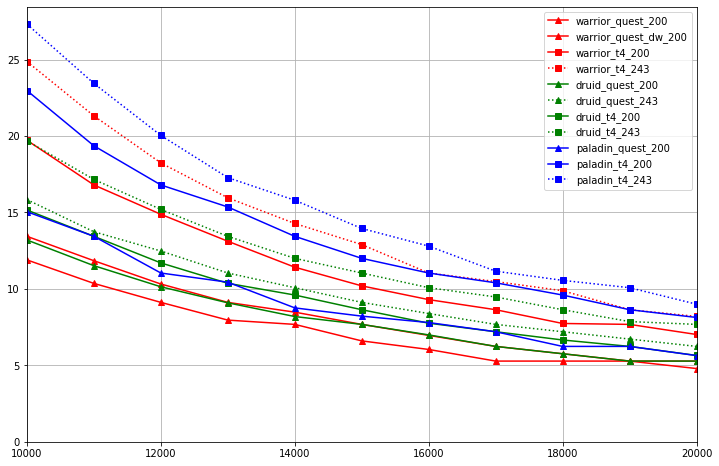

In [993]:
alives = get_by_boss_damage(state_names, p1_2h_boss_state, boss_damages, 
                            lambda sn, p, b: calculate_alive(sn, p, b, iterate_times = 2500))

plot_by_boss_damage(alives, boss_damages)

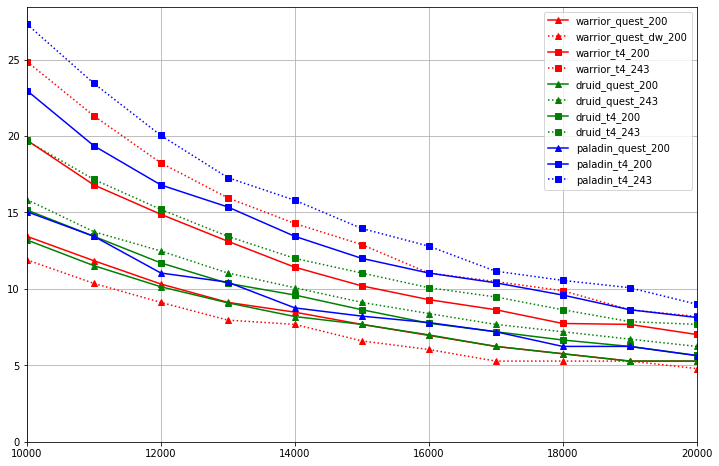

In [1035]:
plot_by_boss_damage(alives, boss_damages)

(0, 15)

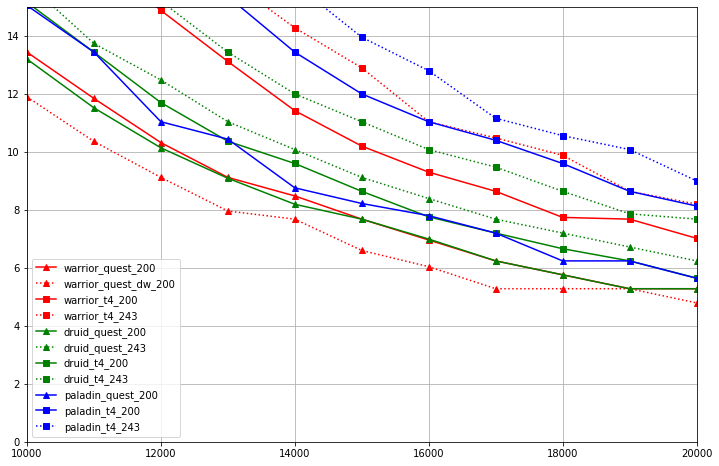

In [1037]:
plot_by_boss_damage(alives, boss_damages)
plt.ylim([0, 15])

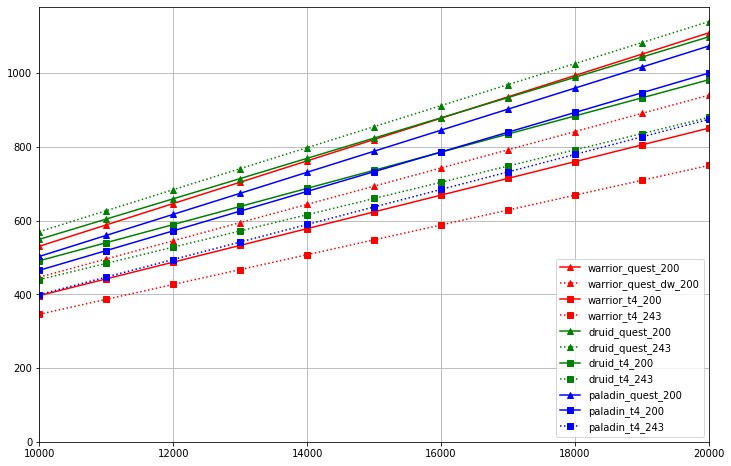

In [998]:
dtpss = get_by_boss_damage(state_names, p1_2h_boss_state, boss_damages, lambda sn, p, b: calculate_dtps(sn, p, b))

plot_by_boss_damage(dtpss, boss_damages)

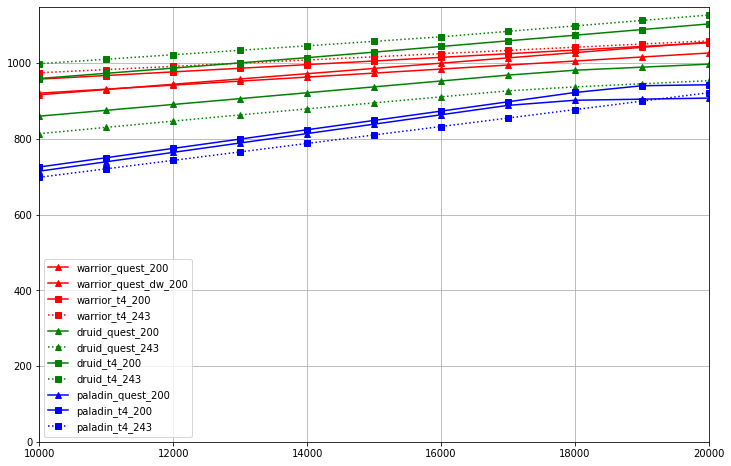

In [930]:
tpss = get_by_boss_damage(state_names, p1_2h_boss_state, boss_damages, lambda sn, p, b: calculate_tps(sn, p, b))

plot_by_boss_damage(tpss, boss_damages)

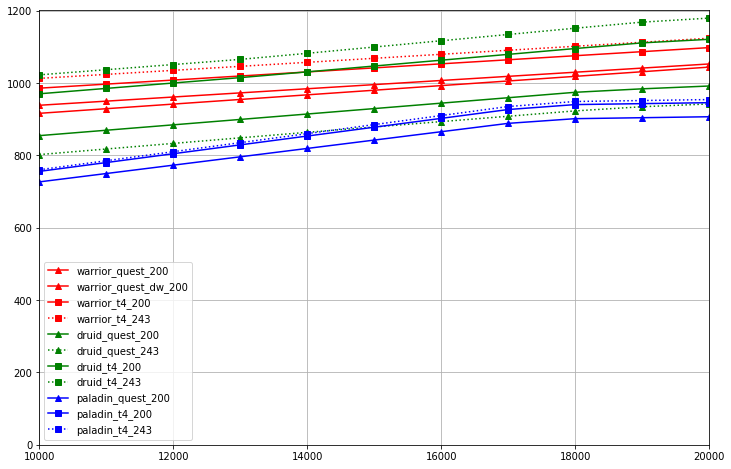

In [992]:
tpss = get_by_boss_damage(state_names, p1_2h_boss_state, boss_damages, lambda sn, p, b: calculate_tps_fix_dtps(sn, p, b, dtps_rate=0.15))

plot_by_boss_damage(tpss, boss_damages)

### dw

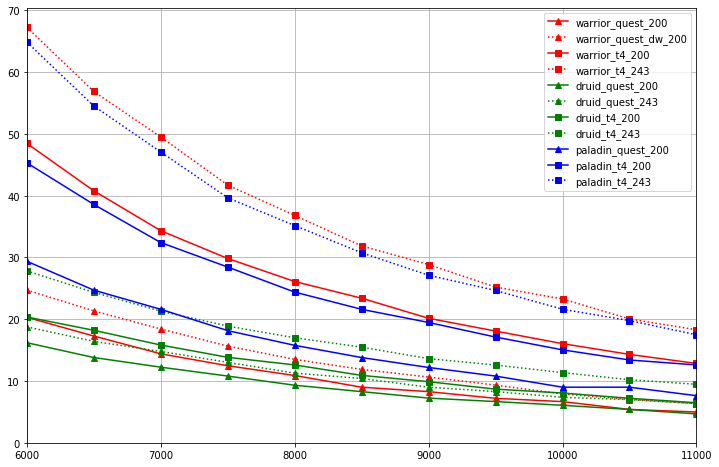

In [999]:
alives_dw = get_by_boss_damage(
    state_names, p1_dw_boss_state, boss_damages_dw, lambda sn, p, b: calculate_alive(sn, p, b, iterate_times = 2500))

plot_by_boss_damage(alives_dw, boss_damages_dw)

(0, 30)

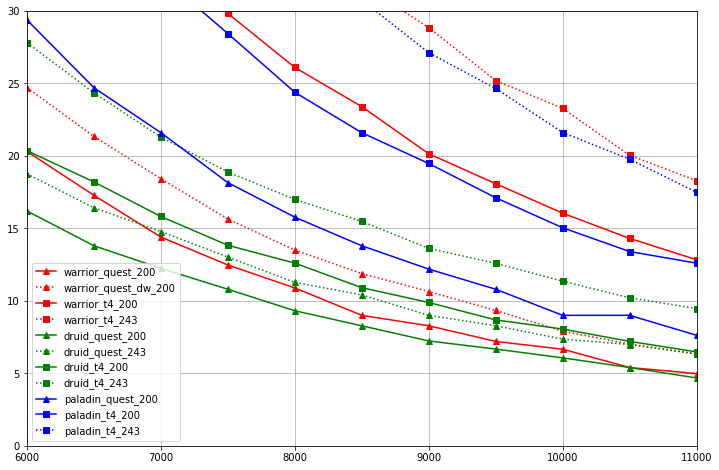

In [1001]:
plot_by_boss_damage(alives_dw, boss_damages_dw)
plt.ylim([0, 30])

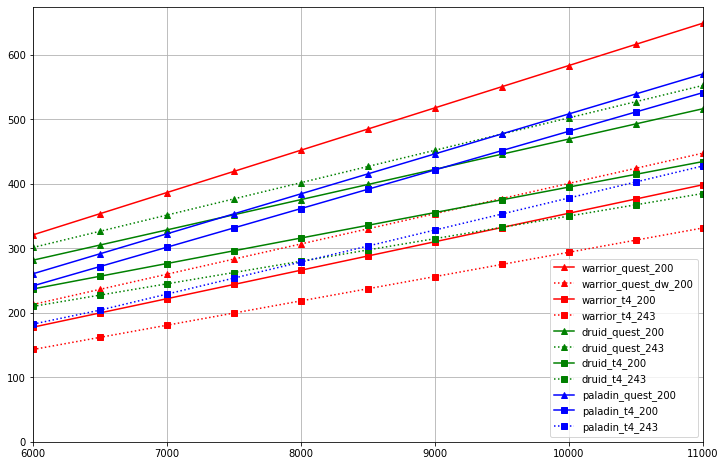

In [1002]:
dtpss_dw = get_by_boss_damage(state_names, p1_dw_boss_state, boss_damages_dw, lambda sn, p, b: calculate_dtps(sn, p, b))

plot_by_boss_damage(dtpss_dw, boss_damages_dw)

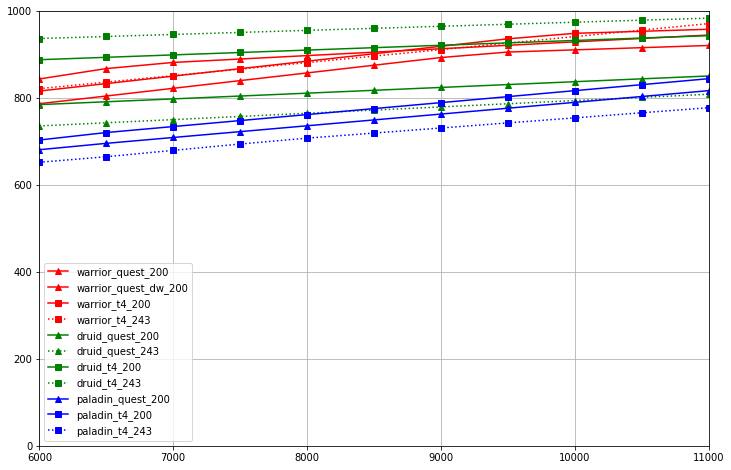

In [991]:
tpss_dw = get_by_boss_damage(state_names, p1_dw_boss_state, boss_damages_dw, lambda sn, p, b: calculate_tps(sn, p, b))

plot_by_boss_damage(tpss_dw, boss_damages_dw)

In [ ]:
boss_damages = [10000+1000*i for i in range(11)]

In [673]:
alives = {}
for sn in state_names:
    player_state = add_raid_buffs(sn, player_states[sn])
    bs = copy.copy(p1_2h_boss_state)
    alives[sn] = []
    for bd in boss_damages:
        bs["damage"] = bd
        alives[sn].append(calculate_alive(sn, player_state, boss_apply_tc_and_demo(bs), iterate_times = 200))

(0, 21.809999999999974)

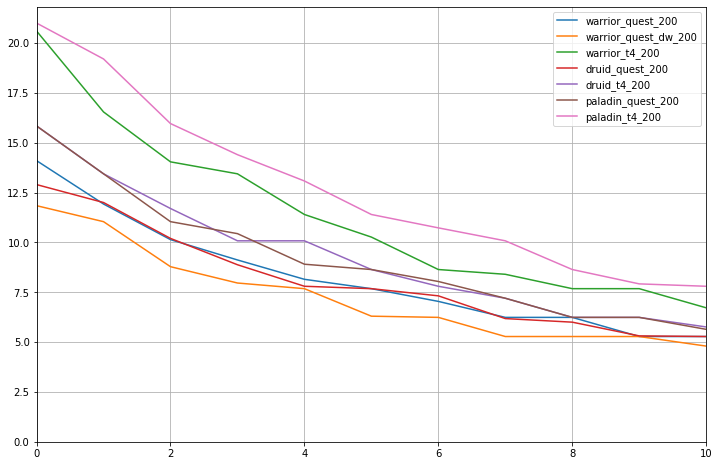

In [689]:
alives_df = pd.DataFrame(alives)

alives_df.plot(figsize=(12,8))
plt.grid("both")
plt.ylim([0,None])

In [684]:
dtpss = get_by_boss_damage(state_names, p1_2h_boss_state, boss_damages, lambda sb, p, b: calculate_dtps(sn, p, b))
for sn in state_names:
    player_state = add_raid_buffs(sn, player_states[sn])
    bs = copy.copy(p1_2h_boss_state)
    dtpss[sn] = []
    for bd in boss_damages:
        bs["damage"] = bd
        dtpss[sn].append()


(0, 1144.9991527515263)

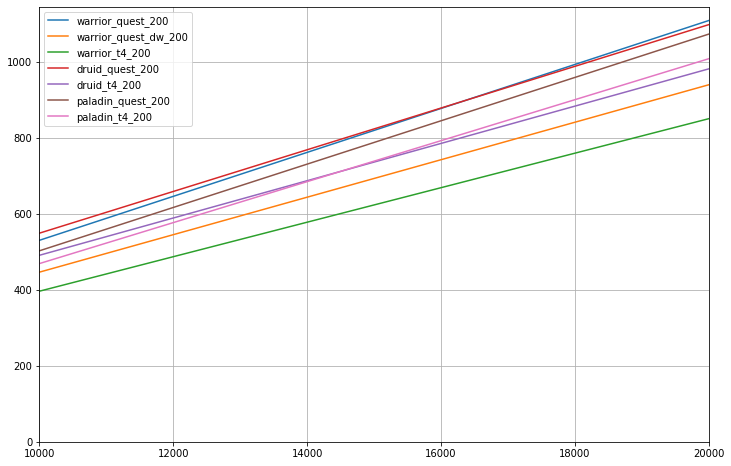

In [688]:
dtpss_df = pd.DataFrame(dtpss, index=boss_damages)

dtpss_df.plot(figsize=(12,8))
plt.grid("both")
plt.ylim([0,None])

# lines

## warrior

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
player_state = copy.copy(warrior_quest_gear_state)
iter_num = 2500
result = get_line_result(
    player_state, boss_state, warrior_alive_states,
    lambda p, b: warrior_calculate_alive_time(warrior_add_raid_buffs(p), b, iter_num), 2)
print(warrior_generate_ag_str("战士_防御_双手_生存_Pre", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
player_state = copy.copy(warrior_quest_gear_state)
iter_num = 200
result = get_line_result(
    player_state, boss_state, warrior_alive_states,
    lambda p, b: warrior_calculate_alive_time(warrior_add_raid_buffs(p), b, iter_num), 2)
print(warrior_generate_ag_str("战士_防御_双手_生存_Pre", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
player_state = copy.copy(warrior_quest_gear_state)
result = get_line_result(
    player_state, boss_state, warrior_dtps_states,
    lambda p, b: warrior_calculate_dtps(warrior_add_raid_buffs(p), b), 200)
print(warrior_generate_ag_str("战士_防御_双手_减伤_Pre", result, True))


In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
player_state = copy.copy(warrior_quest_gear_state)
result = get_line_result(
    player_state, boss_state, warrior_dtps_states,
    lambda p, b: warrior_calculate_dtps_sim(warrior_add_raid_buffs(p), b, 200), 200)
print(warrior_generate_ag_str("战士_防御_双手_减伤_Pre", result, True))


In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
player_state = copy.copy(warrior_quest_gear_state)
def cf(p, b):
    rp = warrior_add_raid_buffs(p)
    return warrior_calculate_tps(rp, warrior_calculate_dtps(rp, b))
result = get_line_result(
    player_state, boss_state, warrior_threat_states, cf , 150)
print(warrior_generate_ag_str("战士_防御_双手_仇恨_Pre", result))


In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_dw_boss_state))
base_state = copy.copy(warrior_quest_dw_gear_state)
base_state["avoid"] += 0.19
iter_num = 2500
result = get_line_result(
    base_state, boss_state, warrior_alive_states,
    lambda p, b: warrior_calculate_alive_time(warrior_add_raid_buffs(p), b, iter_num), 5)
print(warrior_generate_ag_str("战士_防御_双持_生存_PRE", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_dw_boss_state))
base_state = copy.copy(warrior_quest_dw_gear_state)
base_state["avoid"] += 0.19
iter_num = 200
result = get_line_result(
    base_state, boss_state, warrior_alive_states,
    lambda p, b: warrior_calculate_alive_time(warrior_add_raid_buffs(p), b, iter_num), 5)
print(warrior_generate_ag_str("战士_防御_双持_生存_PRE", result))

In [ ]:

boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_dw_boss_state))
base_state = copy.copy(warrior_quest_dw_gear_state)
base_state["avoid"] += 0.19
iter_num = 200
result = get_line_result(base_state, boss_state, warrior_dtps_states, 
                         lambda p, b:warrior_calculate_dtps_sim(warrior_add_raid_buffs(p), b, iter_num), 100)
print(warrior_generate_ag_str("战士_防御_双持_减伤_PRE", result, True))

In [ ]:

boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_dw_boss_state))
base_state = copy.copy(warrior_quest_dw_gear_state)
base_state["avoid"] += 0.19
result = get_line_result(base_state, boss_state, warrior_dtps_states, 
                         lambda p, b:warrior_calculate_dtps(warrior_add_raid_buffs(p), b), 100)
print(warrior_generate_ag_str("战士_防御_双持_减伤_PRE", result, True))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_dw_boss_state))
base_state = copy.copy(warrior_quest_dw_gear_state)
base_state["avoid"] += 0.19
def cf(p, b):
    rp = warrior_add_raid_buffs(p)
    return warrior_calculate_tps(rp, warrior_calculate_dtps(rp, b))
result = get_line_result(
    base_state, boss_state, warrior_threat_states, cf , 150)
print(warrior_generate_ag_str("战士_防御_双持_仇恨_Pre", result))


## druid

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
base_state = copy.copy(druid_quest_gear_state)
iter_num = 2500
result = get_line_result(
    base_state, boss_state, druid_alive_states,
    lambda p, b: druid_calculate_alive_time(druid_add_raid_buffs(p), b, iter_num), 2)
print(druid_generate_ag_str("德鲁伊_防御_双手_生存_Pre", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
base_state = copy.copy(druid_quest_gear_state)
iter_num = 2500
result = get_line_result(
    base_state, boss_state, druid_dtps_states,
    lambda p, b: druid_calculate_dtps(druid_add_raid_buffs(p), b), 300)
print(druid_generate_ag_str("德鲁伊_防御_双手_减伤_Pre", result, True))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
base_state = copy.copy(druid_quest_gear_state)
iter_num = 2500

def cf(p, b):
    rp = druid_add_raid_buffs(p)
    return druid_calculate_tps(rp, druid_calculate_dtps(rp, b))
result = get_line_result(
    base_state, boss_state, druid_threat_states, cf , 150)
print(druid_generate_ag_str("德鲁伊_防御_双手_仇恨_Pre", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_dw_boss_state))
base_state = copy.copy(druid_quest_gear_state)

base_state["avoid"] += 0.19
iter_num = 200
result = get_line_result(
    base_state, boss_state, druid_alive_states,
    lambda p, b: druid_calculate_alive_time(druid_add_raid_buffs(p), b, iter_num), 2)
print(druid_generate_ag_str("德鲁伊_防御_双持_生存_Pre", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_dw_boss_state))
base_state = copy.copy(druid_quest_gear_state)
base_state["avoid"] += 0.19
result = get_line_result(
    base_state, boss_state, druid_dtps_states,
    lambda p, b: druid_calculate_dtps(druid_add_raid_buffs(p), b), 400)
print(druid_generate_ag_str("德鲁伊_防御_双手_减伤_Pre", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_dw_boss_state))
base_state = copy.copy(druid_quest_gear_state)
base_state["avoid"] += 0.19

def cf(p, b):
    rp = druid_add_raid_buffs(p)
    return druid_calculate_tps(rp, druid_calculate_dtps(rp, b))
result = get_line_result(
    base_state, boss_state, druid_threat_states, cf , 200)
print(druid_generate_ag_str("德鲁伊_防御_双手_减伤_Pre", result))

## paladin

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
base_state = copy.copy(paladin_quest_gear_state)
iter_num = 2500
result = get_line_result(
    base_state, boss_state, warrior_alive_states,
    lambda p, b: paladin_calculate_alive_time(paladin_add_raid_buffs(p), b, iter_num), 2)
print(paladin_generate_ag_str("骑士_防御_双手_生存_Pre", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
base_state = copy.copy(paladin_quest_gear_state)
iter_num = 2500
result = get_line_result(
    base_state, boss_state, {"B-damage":warrior_alive_states["B-damage"]},
    lambda p, b: paladin_calculate_alive_time(paladin_add_raid_buffs(p), b, iter_num,), 2)
print(paladin_generate_ag_str("骑士_防御_双手_生存_Pre", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
base_state = copy.copy(paladin_quest_gear_state)
iter_num = 2500
result = get_line_result(
    base_state, boss_state, {"weapon_speed":warrior_alive_states["weapon_speed"]},
    lambda p, b: paladin_calculate_alive_time(paladin_add_raid_buffs(p), b, iter_num), 2)
print(paladin_generate_ag_str("骑士_防御_双手_生存_Pre", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
base_state = copy.copy(paladin_quest_gear_state)
iter_num = 200
result = get_line_result(
    base_state, boss_state, warrior_alive_states,
    lambda p, b: paladin_calculate_alive_time(paladin_add_raid_buffs(p), b, iter_num, has_rev=False), 2)
print(paladin_generate_ag_str("骑士_防御_双手_生存_Pre", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
base_state = copy.copy(paladin_quest_gear_state)
result = get_line_result(
    base_state, boss_state, warrior_dtps_states,
    lambda p, b: paladin_calculate_dtps(paladin_add_raid_buffs(p), b), 200)
print(paladin_generate_ag_str("骑士_防御_双手_减伤_Pre", result, True))


In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_2h_boss_state))
player_state = copy.copy(paladin_quest_gear_state)
def cf(p, b):
    rp = paladin_add_raid_buffs(p)
    return paladin_calculate_tps(rp, b, paladin_calculate_dtps(rp, b))
result = get_line_result(
    player_state, boss_state, paladin_threat_states, cf , 150)
print(paladin_generate_ag_str("骑士_防御_双手_仇恨_Pre", result))


In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_dw_boss_state))
base_state = copy.copy(warrior_quest_gear_state)
iter_num = 200
result = get_line_result(
    base_state, boss_state, warrior_alive_states,
    lambda p, b: paladin_calculate_alive_time(paladin_add_raid_buffs(p), b, iter_num), 2)
print(paladin_generate_ag_str("骑士_防御_双持_生存_Pre", result))

In [ ]:
boss_state = boss_apply_tc_and_demo(copy.deepcopy(p1_dw_boss_state))
player_state = copy.copy(paladin_quest_gear_state)
# player_state["avoid"] += 0.19
def cf(p, b):
    rp = paladin_add_raid_buffs(p)
    return paladin_calculate_tps(rp, b, paladin_calculate_dtps(rp, b))
result = get_line_result(
    player_state, boss_state, paladin_threat_states, cf , 150)
print(paladin_generate_ag_str("骑士_防御_双持_仇恨_Pre", result))
